## Predicting Formula 1 Race Outcomes and Evaluating Betting Performance

### Index

1. **Problem Definition**
2. **Data Collection and Preprocessing**
3. **Exploratory Data Analysis (EDA)**
4. **Feature Engineering**
5. **Modeling Approaches**
   - 5.1. Predicting the Race Winner (Classification)
   - 5.2. Predicting Race Positions (Regression)
   - 5.3. Predicting Race Positions (Multiclass Classification)
6. **Model Evaluation and Comparison**
7. **Betting Odds Analysis**
   - 7.1. Collecting Betting Odds
   - 7.2. Simulating Betting Outcomes
   - 7.3. Evaluating Profitability of Predictions
8. **Insights and Conclusions**
9. **Future Work**


### EDA & Preprocessing

In [1]:
import numpy as np
import pandas as pd

In [2]:
circuits = pd.read_csv('data/circuits.csv')
constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
drivers = pd.read_csv('data/drivers.csv')
qualifying = pd.read_csv('data/qualifying.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')

In [3]:
print("Shape of circuits:", circuits.shape)
print("Shape of constructor_standings:", constructor_standings.shape)
print("Shape of constructors:", constructors.shape)
print("Shape of driver_standings:", driver_standings.shape)
print("Shape of drivers:", drivers.shape)
print("Shape of qualifying:", qualifying.shape)
print("Shape of races:", races.shape)
print("Shape of results:", results.shape)

Shape of circuits: (77, 9)
Shape of constructor_standings: (13271, 7)
Shape of constructors: (212, 5)
Shape of driver_standings: (34595, 7)
Shape of drivers: (859, 9)
Shape of qualifying: (10254, 9)
Shape of races: (1125, 18)
Shape of results: (26519, 18)


Key Observations
Datasets and Sizes:

Small datasets: circuits, constructors, drivers, status.
Medium datasets: constructor_results, constructor_standings, races, results, qualifying, sprint_results.
Large datasets: lap_times, pit_stops.
Columns with IDs:

raceId, driverId, constructorId are central identifiers linking multiple datasets.
Missing Data:

qualifying has missing values in q2 and q3.
races has placeholders like \N in session times.

Common Relationships:

races connects with circuits (via circuitId), results and qualifying (via raceId).
drivers and constructors connect with results (via driverId, constructorId).
lap_times and pit_stops detail race events (via raceId, driverId).

In [4]:
# Merge datasets using INNER JOINs with custom suffixes
merged_data = pd.merge(races, circuits, on="circuitId", how="inner", suffixes=('_races', '_circuits'))
merged_data = pd.merge(merged_data, results, on="raceId", how="inner", suffixes=('', '_results'))
merged_data = pd.merge(merged_data, drivers, on="driverId", how="inner", suffixes=('', '_drivers'))
merged_data = pd.merge(merged_data, constructors, on="constructorId", how="inner", suffixes=('', '_constructors'))
merged_data = pd.merge(merged_data, driver_standings, on=["raceId", "driverId"], how="inner", suffixes=('', '_driver_standings'))
merged_data = pd.merge(merged_data, constructor_standings, on=["raceId", "constructorId"], how="inner", suffixes=('', '_constructor_standings'))
merged_data = pd.merge(merged_data, qualifying, on=["raceId", "driverId"], how="inner", suffixes=('', '_qualifying'))


In [5]:
print(merged_data.shape)
merged_data.describe

(10011, 72)


<bound method NDFrame.describe of        raceId  year  round  circuitId                name_races        date  \
0           1  2009      1          1     Australian Grand Prix  2009-03-29   
1           1  2009      1          1     Australian Grand Prix  2009-03-29   
2           2  2009      2          2      Malaysian Grand Prix  2009-04-05   
3           2  2009      2          2      Malaysian Grand Prix  2009-04-05   
4           3  2009      3         17        Chinese Grand Prix  2009-04-19   
...       ...   ...    ...        ...                       ...         ...   
10006     944  2015     18         18      Brazilian Grand Prix  2015-11-15   
10007     943  2015     17         32        Mexican Grand Prix  2015-11-01   
10008     943  2015     17         32        Mexican Grand Prix  2015-11-01   
10009     942  2015     16         69  United States Grand Prix  2015-10-25   
10010     942  2015     16         69  United States Grand Prix  2015-10-25   

           time  

In [6]:
merged_data.isnull().sum()

raceId                  0
year                    0
round                   0
circuitId               0
name_races              0
                       ..
number_qualifying       0
position_qualifying     0
q1                      0
q2                     13
q3                     27
Length: 72, dtype: int64

veiem que tot i que posa que només hi ha 13 i 27 nuls respectivament hi ha molts valors que son \N i que pertant també son nuls. Començem per canviar \N per NaN

In [7]:
merged_data.replace('\\N', np.nan, inplace=True)

In [8]:
merged_data.isnull().sum()

raceId                    0
year                      0
round                     0
circuitId                 0
name_races                0
                       ... 
number_qualifying         0
position_qualifying       0
q1                      149
q2                     4364
q3                     6509
Length: 72, dtype: int64

Ara si veiem que hi ha molts nuls a q2 i q3. Understanding the Problem
q1: Represents all drivers with qualifying times (minimal missing values).
q2: Only available for the top 15 fastest drivers from q1.
q3: Only available for the top 10 fastest drivers from q2.
These missing values are not random but instead a result of the qualification rules. They carry information about the driver's performance and ranking. For example:

A missing value in q2 means the driver did not make it past q1.
A missing value in q3 means the driver did not make it past q2.

El format de classificació de 3 rondes es va introudir al 2006 i llavors només tindria sentit posar columens binàries sobre si van passar q1 i la q2 a partir del 2006. Per simplificar eliminaré les columnes q2 i q3

In [9]:
merged_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'name_races', 'date', 'time',
       'url_races', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'circuitRef', 'name_circuits', 'location', 'country', 'lat', 'lng',
       'alt', 'url_circuits', 'resultId', 'driverId', 'constructorId',
       'number', 'grid', 'position', 'positionText', 'positionOrder', 'points',
       'laps', 'time_results', 'milliseconds', 'fastestLap', 'rank',
       'fastestLapTime', 'fastestLapSpeed', 'statusId', 'driverRef',
       'number_drivers', 'code', 'forename', 'surname', 'dob', 'nationality',
       'url', 'constructorRef', 'name', 'nationality_constructors',
       'url_constructors', 'driverStandingsId', 'points_driver_standings',
       'position_driver_standings', 'positionText_driver_standings', 'wins',
       'constructorStandingsId', 'points_constructor_standings',
       'position_constructor_standings'

In [10]:
# Columns to drop
columns_to_drop = [
    'driverId', 'constructorId', 'statusId', 'qualifyId', 'constructorResultsId', 'constructorStandingsId', 'driverStandingsId',
    'url_races', 'tiime', 'url_circuits', 'number', 'url_results', 'url', 'code', 'url_drivers', 'resultId', 'q2', 'q3',
    'name_circuits', 'location', 'lat', 'lng', 'alt', 'url_drivers', 'constructorStandingsId', 'time', 'driverRef',
    'number', 'code', 'url_constructors', 'url_driver_standings', 'positionText', 'positionOrder', 'position_qualifying',
    'time_results', 'milliseconds', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'number_drivers',
    'positionText_driver_standings', 'constructorId_qualifying', 'number_qualifying', 'position_qualifying',
    'positionText_constructor_standings', 'positionOrder_constructor_standings', 'points_constructor_standings',
    'wins_constructor_standings', 'positionText_constructor_standings', 'constructorRef', 'position_constructor_standings',
    'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time'
]


# Lists of status IDs
driver_error_status_ids = [3, 4, 20, 28, 68, 73, 82, 89, 100, 104, 107, 130, 139]
constructor_error_status_ids = [
    5, 6, 7, 8, 9, 10, 21, 22, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 35, 36, 37,
    38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 59, 60, 61, 63, 64, 65, 66,
    67, 69, 70, 71, 72, 74, 75, 76, 79, 80, 83, 84, 86, 87, 91, 94, 95, 98, 99,
    101, 102, 103, 105, 106, 108, 109, 110, 121, 126, 129, 131, 132, 135, 140, 141
]
finished_status_ids = [
    1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 45, 50, 53, 55, 88,
    111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 122, 123,
    124, 125, 127, 128, 133, 134
]

# Initialize columns with zeros
merged_data['driver_dnf'] = 0
merged_data['constructor_dnf'] = 0

# Set driver_dnf to 1 where statusId is a driver error
merged_data.loc[merged_data['statusId'].isin(driver_error_status_ids), 'driver_dnf'] = 1

# Set constructor_dnf to 1 where statusId is a constructor error
merged_data.loc[merged_data['statusId'].isin(constructor_error_status_ids), 'constructor_dnf'] = 1

# Ensure that drivers who finished the race have zeros in both columns
merged_data.loc[merged_data['statusId'].isin(finished_status_ids), ['driver_dnf', 'constructor_dnf']] = 0

# Drop the specified columns
merged_data = merged_data.drop(columns=columns_to_drop, errors='ignore')



In [11]:
merged_data.head()

,raceId,year,round,circuitId,name_races,date,circuitRef,country,grid,position,...,dob,nationality,name,nationality_constructors,points_driver_standings,position_driver_standings,wins,q1,driver_dnf,constructor_dnf
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,1980-01-19,British,Brawn,British,10.0,1,1,1:25.211,0,0
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,1972-05-23,Brazilian,Brawn,British,8.0,2,0,1:25.006,0,0
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,1980-01-19,British,Brawn,British,15.0,1,2,1:35.058,0,0
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,1972-05-23,Brazilian,Brawn,British,10.0,2,0,1:34.681,0,0
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,1980-01-19,British,Brawn,British,21.0,1,2,1:35.533,0,0


In [12]:
merged_data.rename(columns={
    'name_races': 'GP_name',
    'nationality': 'driver_nationality',
    'points_driver_standings': 'total_points',
    'position_driver_standings': 'championship_position',
    'name': 'constructor_name',
    'wins' : 'number_wins'
}, inplace = True)

In [13]:
merged_data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'GP_name', 'date', 'circuitRef',
       'country', 'grid', 'position', 'points', 'laps', 'forename', 'surname',
       'dob', 'driver_nationality', 'constructor_name',
       'nationality_constructors', 'total_points', 'championship_position',
       'number_wins', 'q1', 'driver_dnf', 'constructor_dnf'],
      dtype='object')

In [14]:
# Combine 'forename' and 'surname' into a single column called 'driver_name'
merged_data['driver_name'] = merged_data['forename'] + ' ' + merged_data['surname']

# Drop the original 'forename' and 'surname' columns as they are no longer needed
merged_data = merged_data.drop(columns=['forename', 'surname'], errors='ignore')

#tranform the 'dob' and 'date' column to datetime
merged_data['dob'] = pd.to_datetime(merged_data['dob'])
merged_data['date'] = pd.to_datetime(merged_data['date'])
# Calculate the age of the driver at the time of the Grand Prix in days
merged_data['age_at_gp_in_days'] = (merged_data['date'] - merged_data['dob']).dt.days


# Display the first few rows to confirm the changes
merged_data.head()

,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,constructor_name,nationality_constructors,total_points,championship_position,number_wins,q1,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days
0,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,1,1,...,Brawn,British,10.0,1,1,1:25.211,0,0,Jenson Button,10662
1,1,2009,1,1,Australian Grand Prix,2009-03-29,albert_park,Australia,2,2,...,Brawn,British,8.0,2,0,1:25.006,0,0,Rubens Barrichello,13459
2,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,1,1,...,Brawn,British,15.0,1,2,1:35.058,0,0,Jenson Button,10669
3,2,2009,2,2,Malaysian Grand Prix,2009-04-05,sepang,Malaysia,8,5,...,Brawn,British,10.0,2,0,1:34.681,0,0,Rubens Barrichello,13466
4,3,2009,3,17,Chinese Grand Prix,2009-04-19,shanghai,China,5,3,...,Brawn,British,21.0,1,2,1:35.533,0,0,Jenson Button,10683


In [15]:
nationality_to_country = {
    "German": "Germany",
    "Dutch": "Netherlands",
    "British": "UK",
    "Brazilian": "Brazil",
    "Finnish": "Finland",
    "French": "France",
    "Austrian": "Austria",
    "Italian": "Italy",
    "Japanese": "Japan",
    "Australian": "Australia",
    "Portuguese": "Portugal",
    "Monegasque": "Monaco",
    "Belgian": "Belgium",
    "Swiss": "Switzerland",
    "Danish": "Denmark",
    "Canadian": "Canada",
    "Argentine": "Argentina",
    "Spanish": "Spain",
    "Colombian": "Colombia",
    "Czech": "Czech Republic",
    "Malaysian": "Malaysia",
    "Irish": "Ireland",
    "Hungarian": "Hungary",
    "Indian": "India",
    "American": "USA",
    "Polish": "Poland",
    "Russian": "Russia",
    "Venezuelan": "Venezuela",
    "Mexican": "Mexico",
    "Swedish": "Sweden",
    "Indonesian": "Indonesia",
    "New Zealander": "New Zealand",
    "Thai": "Thailand",
}

In [16]:
# Map driver_nationality to driver_country using the nationality_to_country dictionary
merged_data['driver_country'] = merged_data['driver_nationality'].map(nationality_to_country)

merged_data['constructor_country'] = merged_data['nationality_constructors'].map(nationality_to_country)

# drop driver_nationality column
merged_data.drop(columns=['driver_nationality','nationality_constructors' ], inplace=True)

In [17]:
merged_data = merged_data.sort_values(by=['year', 'round'])

In [18]:
merged_data.to_csv('data/merged_data.csv', index=False)

### Step 1: Data Structure Analysis

In [19]:
# Step 1: Understand the Data Structure

# Display the shape of the dataset
dataset_shape = merged_data.shape

# List column names and their data types
column_info = merged_data.dtypes

# Sample unique values for each column
unique_values_sample = merged_data.nunique()

# Check for missing values in each column
missing_values = merged_data.isnull().sum()

# Compile the information into a summary table
data_overview = pd.DataFrame({
    "Data Type": column_info,
    "Unique Values": unique_values_sample,
    "Missing Values": missing_values,
    "Missing %": (missing_values / dataset_shape[0]) * 100
})


dataset_shape, data_overview


((10011, 24),
                             Data Type  Unique Values  Missing Values  \
 raceId                          int64            482               0   
 year                            int64             31               0   
 round                           int64             22               0   
 circuitId                       int64             43               0   
 GP_name                        object             43               0   
 date                   datetime64[ns]            482               0   
 circuitRef                     object             43               0   
 country                        object             31               0   
 grid                            int64             27               0   
 position                       object             24            2176   
 points                        float64             29               0   
 laps                            int64             85               0   
 dob                    datetime64[ns

### Observations:

- Dataset Size: The dataset contains 8,131 rows and 20 columns.
- Column Overview: Columns include a mix of numerical (e.g., grid, laps), categorical (e.g., GP_name, position), and datetime (e.g., date, dob) types.
- Unique Values: Several columns, such as driver_name and constructor_name, have high cardinality, indicating diversity in data points.
- Missing Data: There are no missing values in the dataset.

### Step 2: Summary Statistics

In [20]:
# Step 2: Summary Statistics

# Generate descriptive statistics for numeric columns
numeric_summary = merged_data.describe()

# Display statistics for categorical columns
categorical_summary = merged_data.select_dtypes(include=['object']).describe()

numeric_summary, categorical_summary


(            raceId          year         round     circuitId          grid  \
 count  10011.00000  10011.000000  10011.000000  10011.000000  10011.000000   
 mean     623.19059   2011.222256      9.839576     19.672161     10.982020   
 std      425.01072      8.362961      5.574044     20.538402      6.271216   
 min        1.00000   1994.000000      1.000000      1.000000      0.000000   
 25%      156.00000   2006.000000      5.000000      7.000000      6.000000   
 50%      870.00000   2012.000000     10.000000     13.000000     11.000000   
 75%     1000.00000   2018.000000     14.000000     22.000000     16.000000   
 max     1132.00000   2024.000000     22.000000     80.000000     26.000000   
 
              points          laps  total_points  championship_position  \
 count  10011.000000  10011.000000  10011.000000           10011.000000   
 mean       3.614424     52.098691     36.577515              11.388672   
 std        6.067520     19.364387     61.251544              


### Key Insights:

- Numerical Summary:
    - Columns like grid and laps have wide ranges, which suggests varying conditions across races.
    - Some variables like total_points and championship_position could potentially be strong predictors for the winner.

- Categorical Summary:
    - GP_name has 31 unique values, which corresponds to different Grand Prix events.
    - driver_name has 156 unique entries, reflecting a diverse set of participants.
    - Variables such as q1, q2, and q3 include significant amounts of non-informative data (\N), which may require cleaning or imputation.

In [21]:
# Convert 'position' column to numeric, forcing errors to NaN
merged_data['position'] = pd.to_numeric(merged_data['position'], errors='coerce')

# Assign a distinct position value for DNFs based on the maximum position in each race
merged_data['position'] = merged_data.groupby('raceId')['position'].transform(lambda x: x.fillna(x.max() + 1)).astype(int)

# Display the updated dataset structure and a sample to confirm changes
updated_sample = merged_data[['raceId', 'position']].head()
print(updated_sample)


      raceId  position
829      257         1
830      257        13
1525     257         2
1526     257        13
2528     257        13


In [22]:
# Step 2: Add a `winner` column
# Create a new column where 1 indicates the driver who finished first, 0 otherwise
merged_data['winner'] = (merged_data['position'] == 1).astype(int)

# Display the updated dataset structure and a sample to confirm changes
updated_sample = merged_data[['raceId', 'position', 'winner']].head()

updated_sample

,raceId,position,winner
829,257,1,1
830,257,13,0
1525,257,2,0
1526,257,13,0
2528,257,13,0


In [23]:
missing_values = merged_data.isnull().sum()
missing_values

raceId                     0
year                       0
round                      0
circuitId                  0
GP_name                    0
date                       0
circuitRef                 0
country                    0
grid                       0
position                   0
points                     0
laps                       0
dob                        0
constructor_name           0
total_points               0
championship_position      0
number_wins                0
q1                       149
driver_dnf                 0
constructor_dnf            0
driver_name                0
age_at_gp_in_days          0
driver_country            56
constructor_country        0
winner                     0
dtype: int64

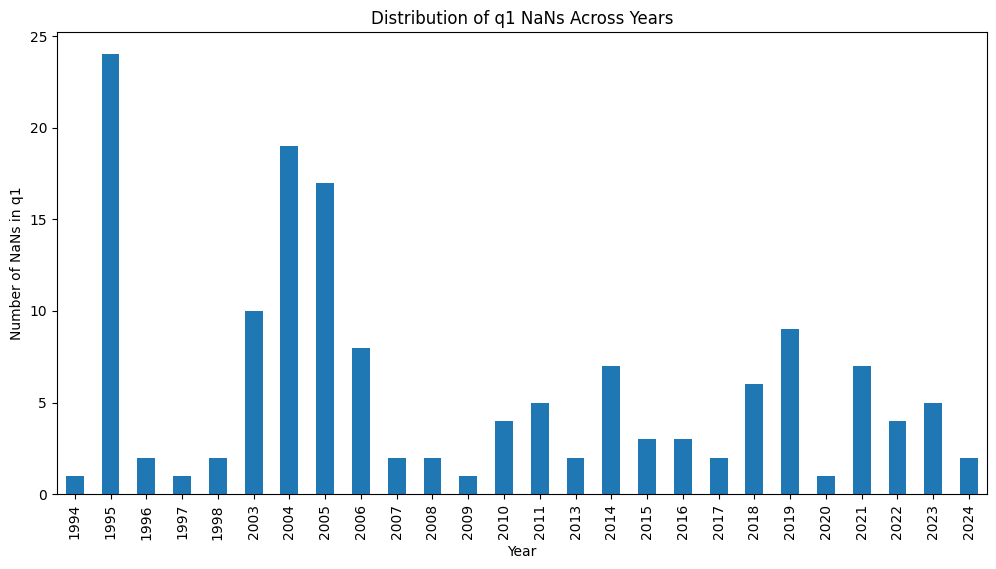

In [24]:
import matplotlib.pyplot as plt

# Count the number of NaNs in 'q1' for each year
q1_nans_per_year = merged_data[merged_data['q1'].isna()].groupby('year').size()

# Plot the results
plt.figure(figsize=(12, 6))
q1_nans_per_year.plot(kind='bar')
plt.title('Distribution of q1 NaNs Across Years')
plt.xlabel('Year')
plt.ylabel('Number of NaNs in q1')
plt.show()

veiem que els nuls estan distribuits al llarg dels anys. després d'analitzar una mica el dataset me n'he adonat que els nuls a q1 són degut a problemes mecanics o accidents dels pilots durant la classificació que fa que surtin des del pit lane (grid == 0), que després ho canviaré al darrera posició en comptes de 0, ja que sinó afecta a la correlació de les variables. 

Per tractar els nuls de q1 he fet el seguent: 

first convert q1 column to seconds. then input the missing values with the mean of the q1 for that particular race

In [25]:
def convert_to_seconds(time_str):
    if pd.isna(time_str) or time_str in ['0', '', 'N/A']:
        return np.nan
    try:
        if ':' in time_str:
            minutes, seconds = time_str.split(':')
            return int(minutes) * 60 + float(seconds)
        else:
            return float(time_str)
    except (ValueError, TypeError):
        return np.nan

In [26]:
# Count remaining NaNs in q1_seconds
merged_data['q1_seconds'] = merged_data['q1'].apply(convert_to_seconds)
num_nans = merged_data['q1_seconds'].isna().sum()
print(f"Number of NaNs in q1_seconds: {num_nans}")


Number of NaNs in q1_seconds: 149


In [27]:
# Calculate mean q1_seconds per race
mean_q1_per_race = merged_data.groupby('raceId')['q1_seconds'].transform('mean')

# Impute missing q1_seconds with race mean
merged_data['q1_seconds'] = merged_data['q1_seconds'].fillna(mean_q1_per_race)


In [28]:
# Count remaining NaNs in q1_seconds
num_nans = merged_data['q1_seconds'].isna().sum()
print(f"Number of NaNs in q1_seconds after reapplying the function: {num_nans}")

Number of NaNs in q1_seconds after reapplying the function: 24


In [29]:
# Drop rows with any remaining NaNs
merged_data.dropna(inplace=True)

# Drop the 'q1' column
merged_data.drop(columns=['q1'], inplace=True)

# Display the first few rows to confirm the changes
merged_data.head()

,raceId,year,round,circuitId,GP_name,date,circuitRef,country,grid,position,...,championship_position,number_wins,driver_dnf,constructor_dnf,driver_name,age_at_gp_in_days,driver_country,constructor_country,winner,q1_seconds
829,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,2,1,...,1,1,0,0,Michael Schumacher,9214,Germany,Italy,1,76.290
830,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,9,13,...,16,0,1,0,Jos Verstappen,8058,Netherlands,Italy,0,78.183
1525,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,4,2,...,2,0,0,0,Damon Hill,12244,UK,UK,0,77.554
1526,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,1,13,...,13,0,1,0,Ayrton Senna,12424,Brazil,UK,0,75.962
2528,257,1994,1,18,Brazilian Grand Prix,1994-03-27,interlagos,Brazil,8,13,...,21,0,0,1,Mika Häkkinen,9311,Finland,UK,0,78.122


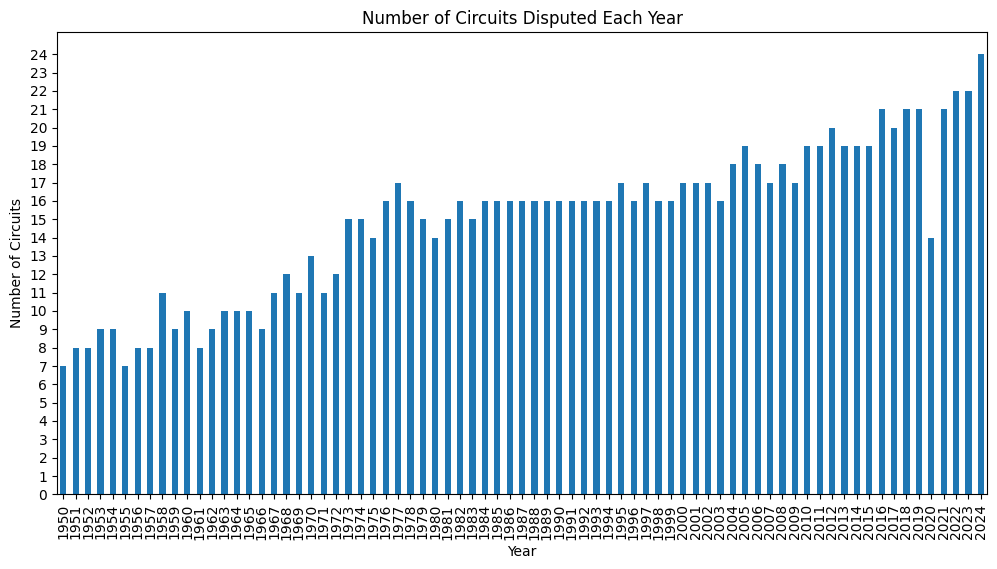

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by year and count the number of unique circuits
circuits_per_year = races.groupby('year')['circuitId'].nunique()

# Plot the results
plt.figure(figsize=(12, 6))
circuits_per_year.plot(kind='bar')
plt.title('Number of Circuits Disputed Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Circuits')
plt.yticks(range(0, int(circuits_per_year.max()) + 1))  # Set y-axis to integer values
plt.show()

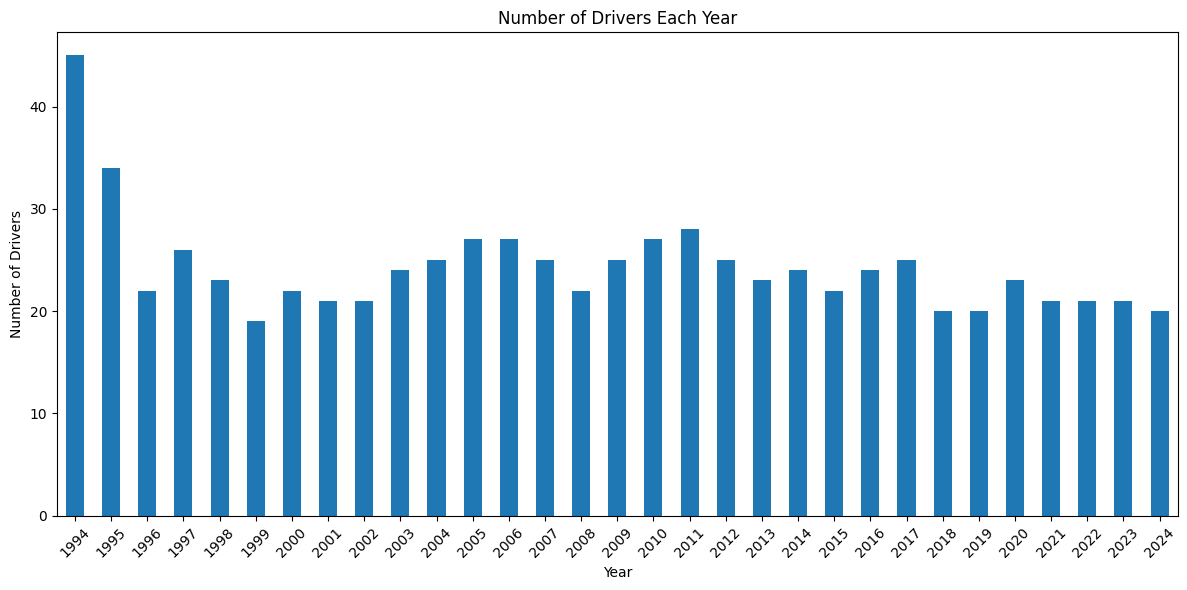

In [31]:
import matplotlib.pyplot as plt

# Group by year and count the number of unique drivers
drivers_per_year = merged_data.groupby('year')['driver_name'].nunique()

# Plot the results
plt.figure(figsize=(12, 6))
drivers_per_year.plot(kind='bar')
plt.title('Number of Drivers Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Drivers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
import matplotlib.pyplot as plt

def plot_wins_driver(results, threshold=1):
    # Your existing data manipulation steps
    winners = results[results['positionOrder'] == 1].merge(races, on='raceId')
    wins_per_driver = winners.groupby(['driverId', 'year']).size().unstack(fill_value=0)

    # Calculate total wins per driver
    total_wins_per_driver = wins_per_driver.sum(axis=1)

    # Merge with drivers to get surnames
    total_wins_per_driver = total_wins_per_driver.reset_index().merge(drivers[['driverId', 'surname']], on='driverId')

    # Filter out drivers with 0 wins
    total_wins_per_driver = total_wins_per_driver[total_wins_per_driver[0] > threshold]

    # Plot the results
    plt.figure(figsize=(15, 6))  # Increase figure size for better spacing
    ax = total_wins_per_driver.set_index('surname')[0].sort_values(ascending=False).plot(kind='bar', color='blue')

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right
    plt.title('Total Wins Per Driver')
    plt.xlabel('Driver Surname')
    plt.ylabel('Number of Wins')
    plt.grid(axis='y')

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

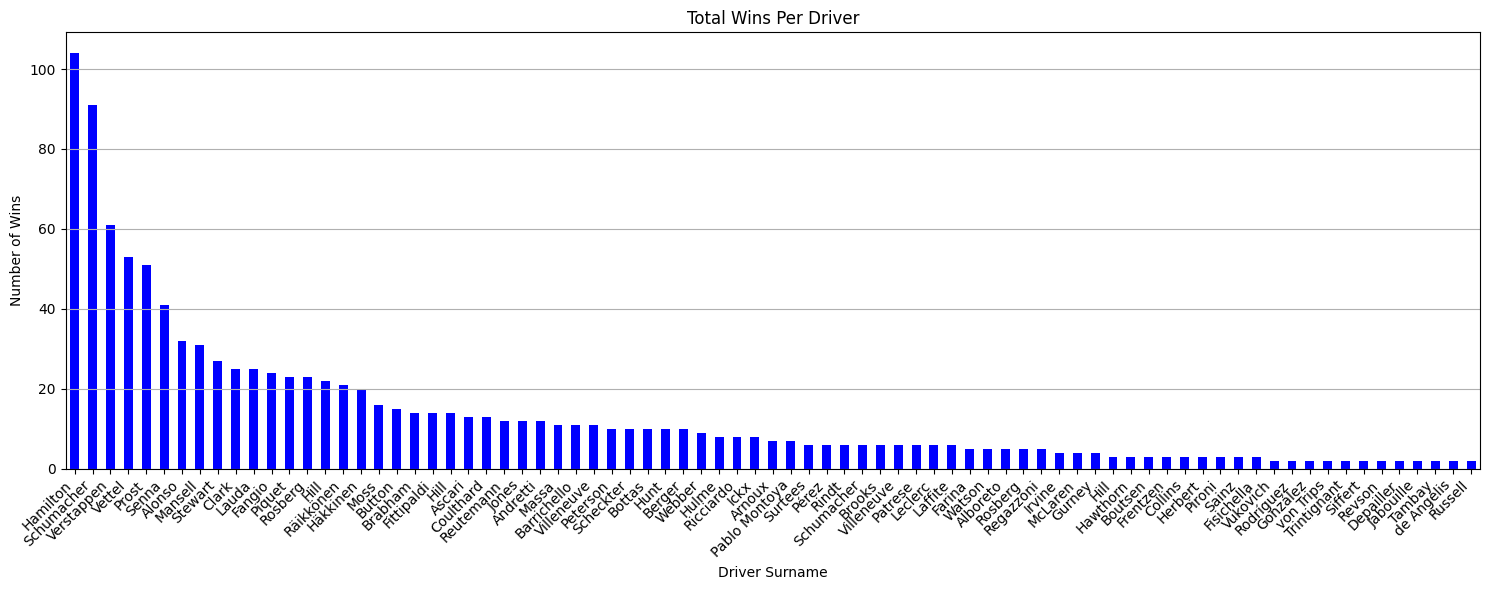

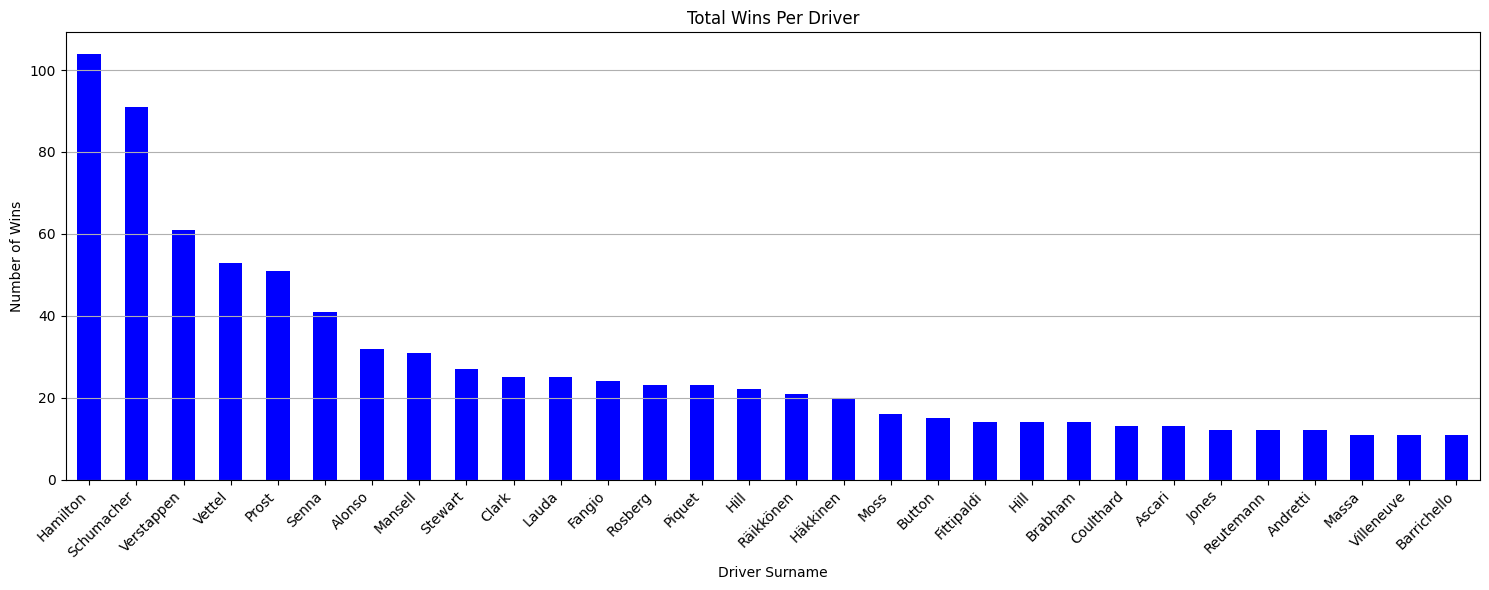

In [33]:
plot_wins_driver(results)
plot_wins_driver(results, threshold=10)

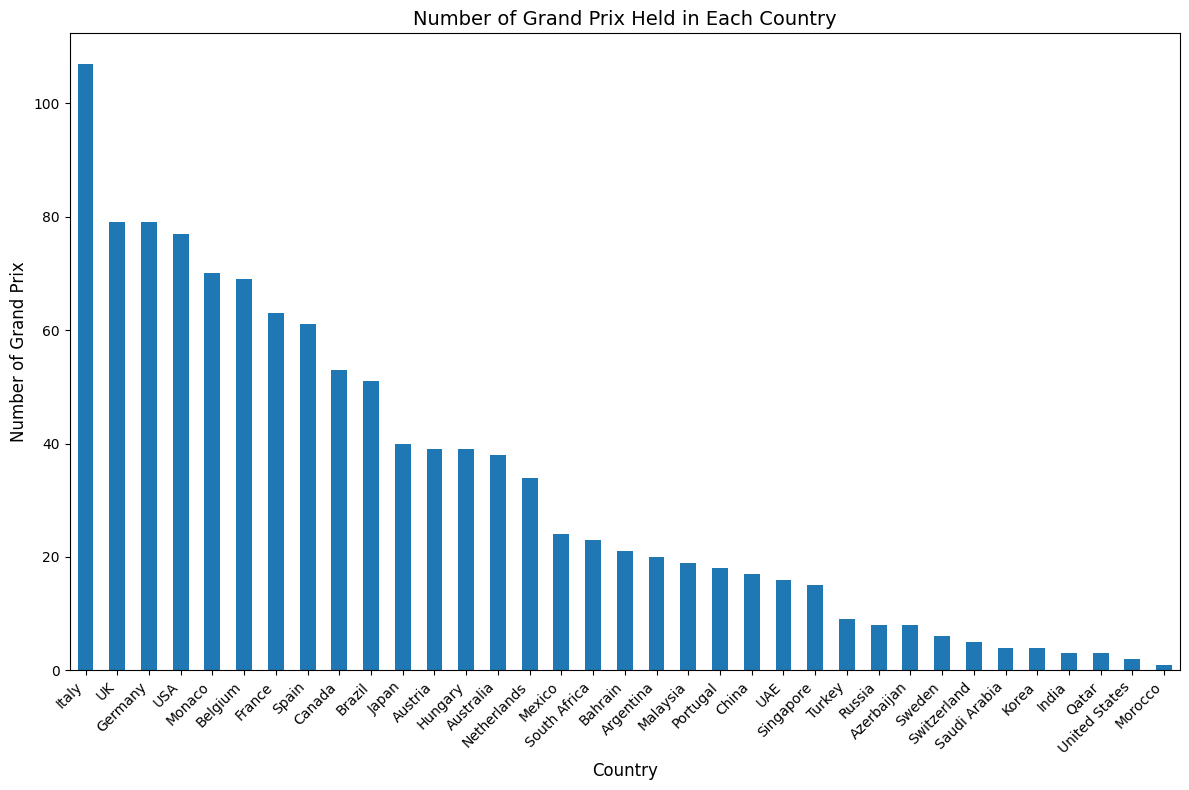

In [34]:
merged_df = pd.merge(races, circuits, left_on='circuitId', right_on='circuitId')
gp_by_country = merged_df['country'].value_counts()

# Plot the results
plt.figure(figsize=(12, 8))
gp_by_country.plot(kind='bar')
plt.title('Number of Grand Prix Held in Each Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Grand Prix', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

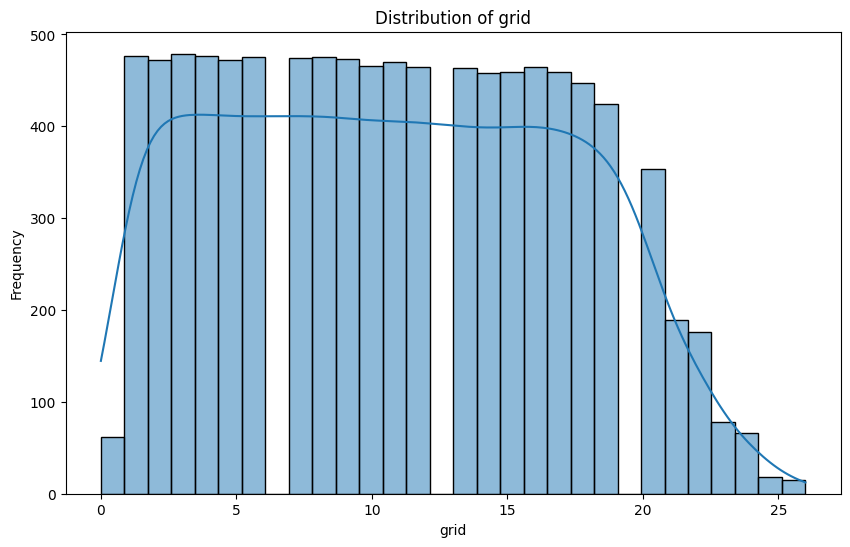

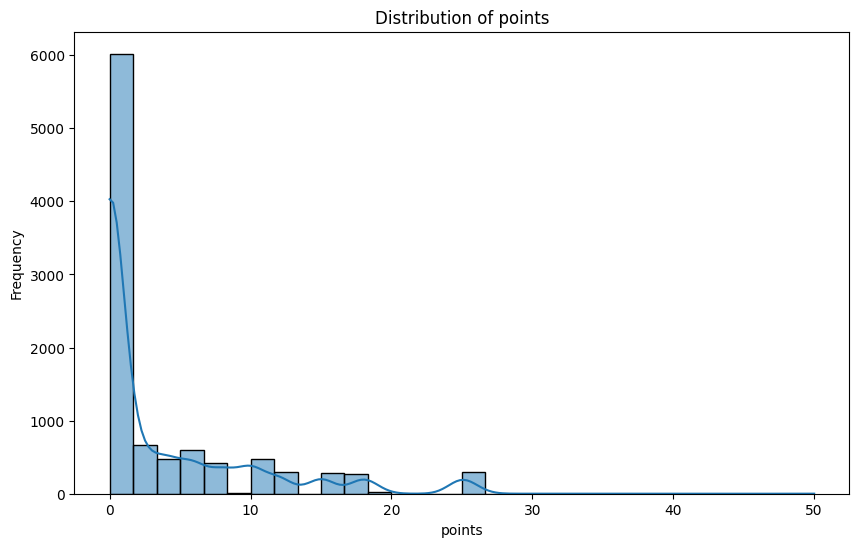

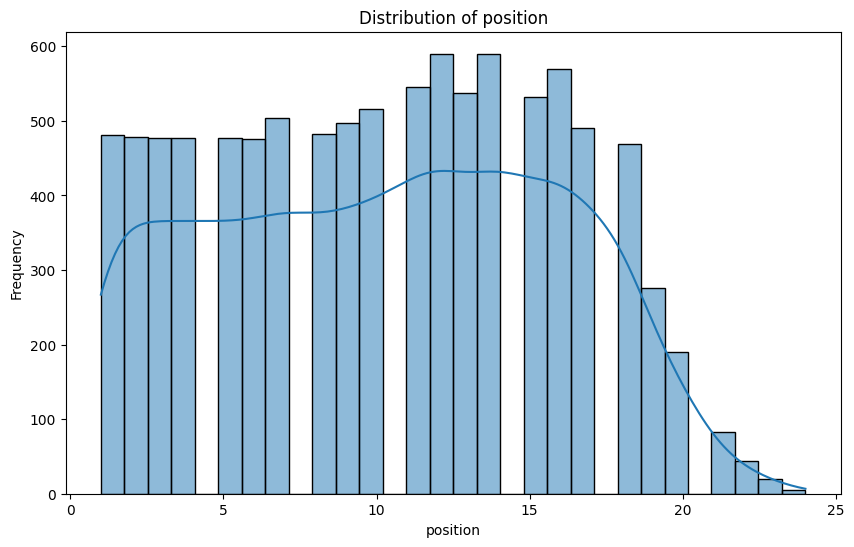

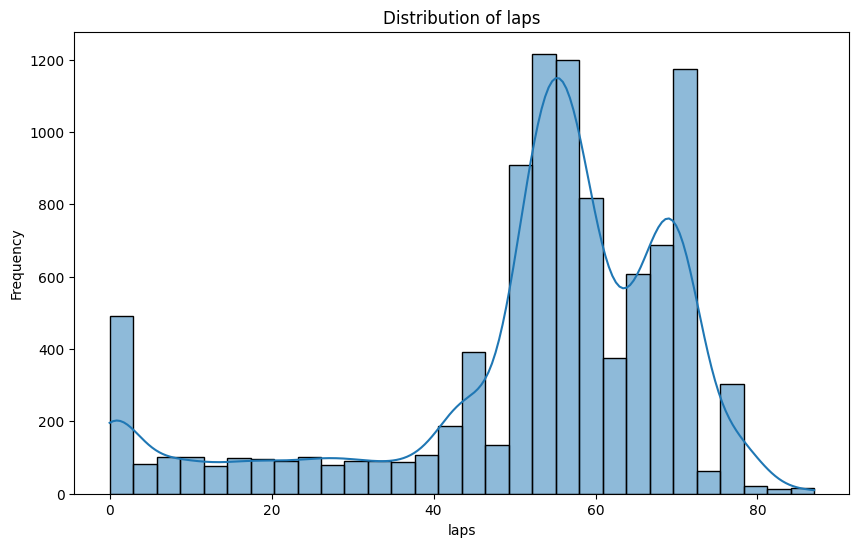

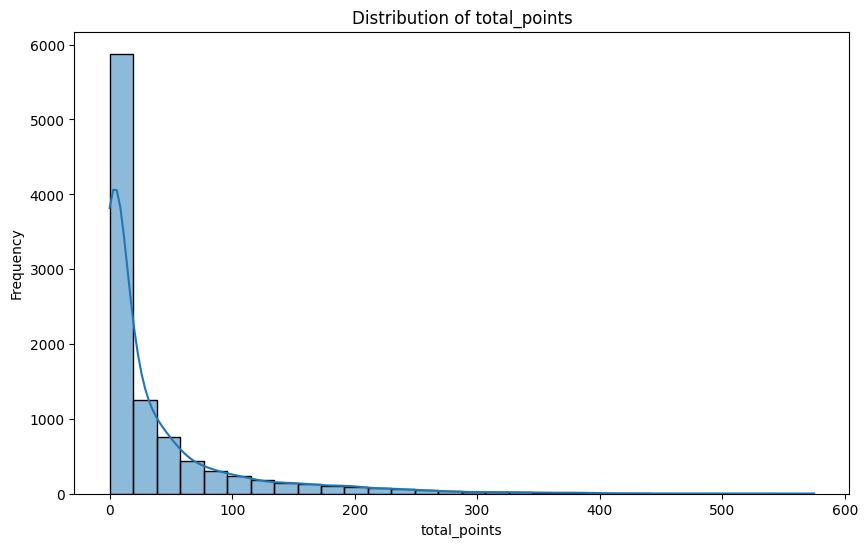

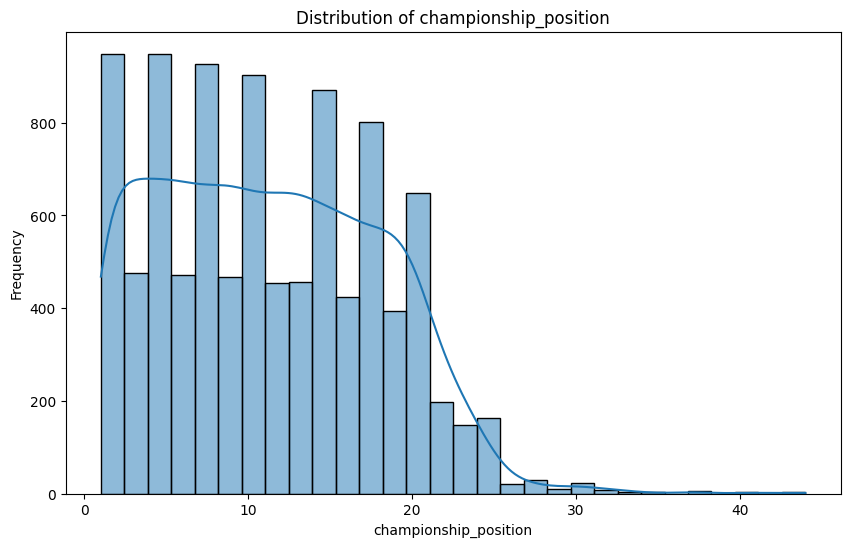

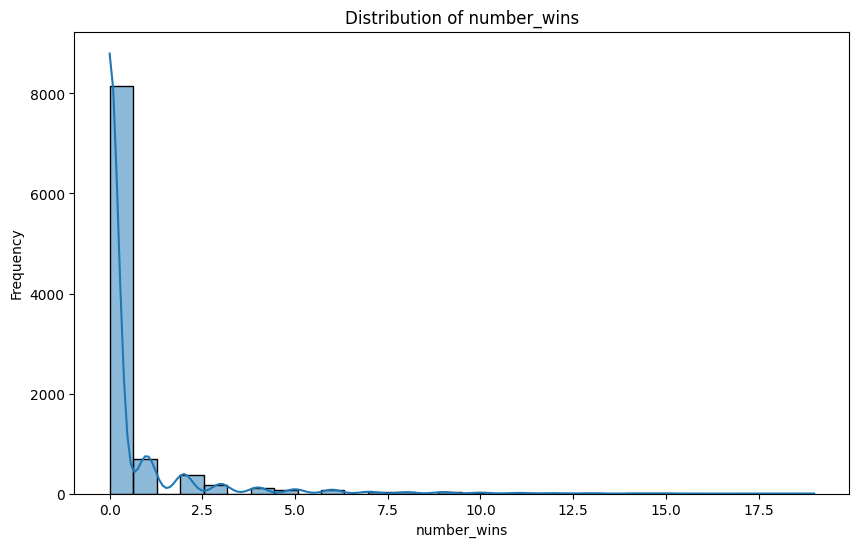

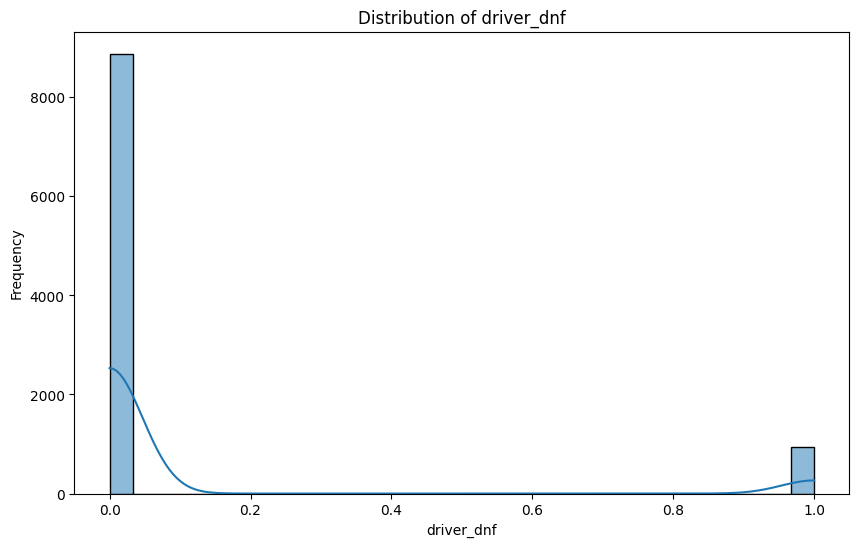

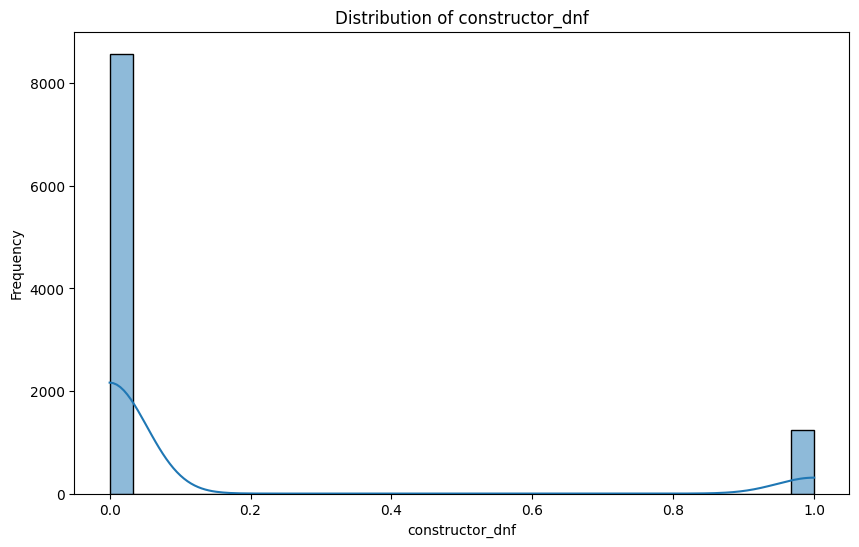

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical columns to plot
numerical_columns = ['grid', 'points', 'position', 'laps', 'total_points', 'championship_position', 'number_wins', 'driver_dnf', 'constructor_dnf']

# Plot histograms and KDEs for numerical variables
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

C:\Users\joelc\AppData\Local\Temp\ipykernel_8900\2968168162.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_data.corr()


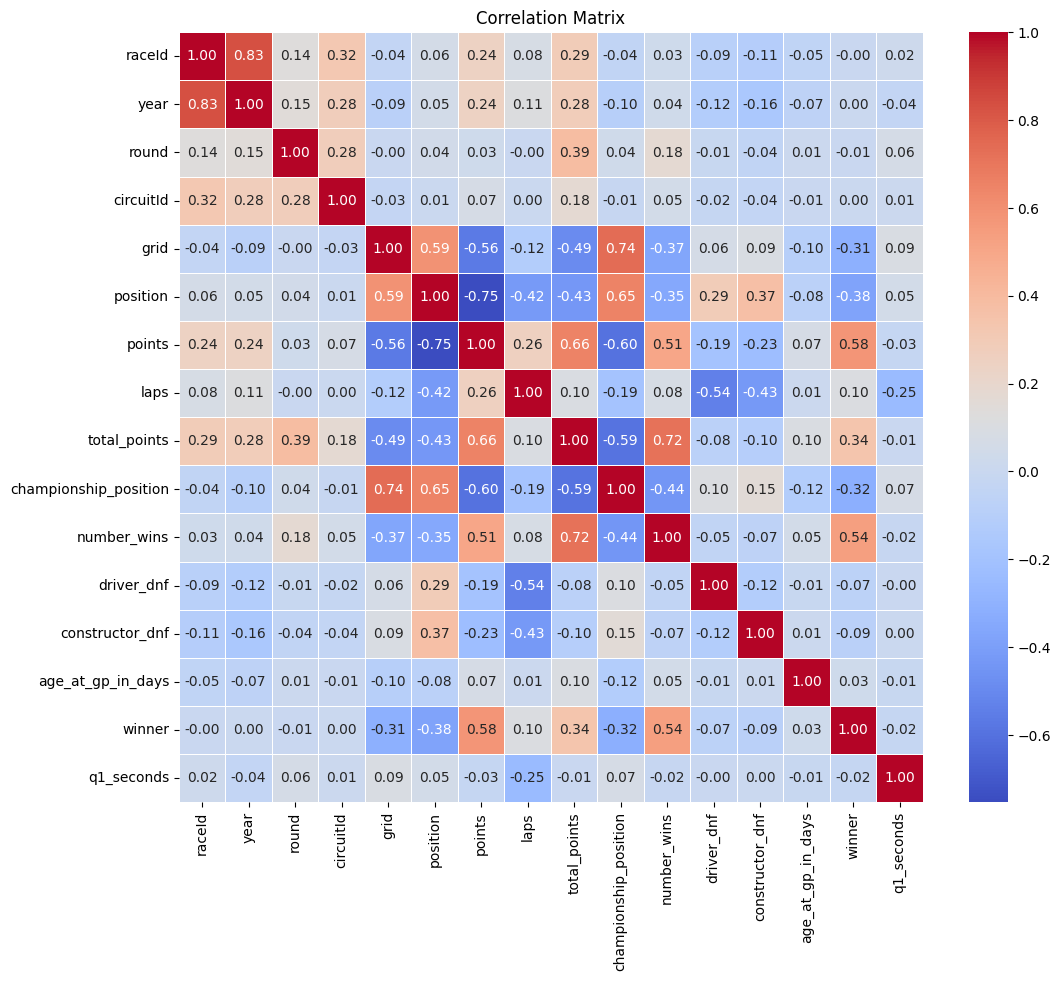

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Explore correlations between numerical variables
correlation_matrix = merged_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

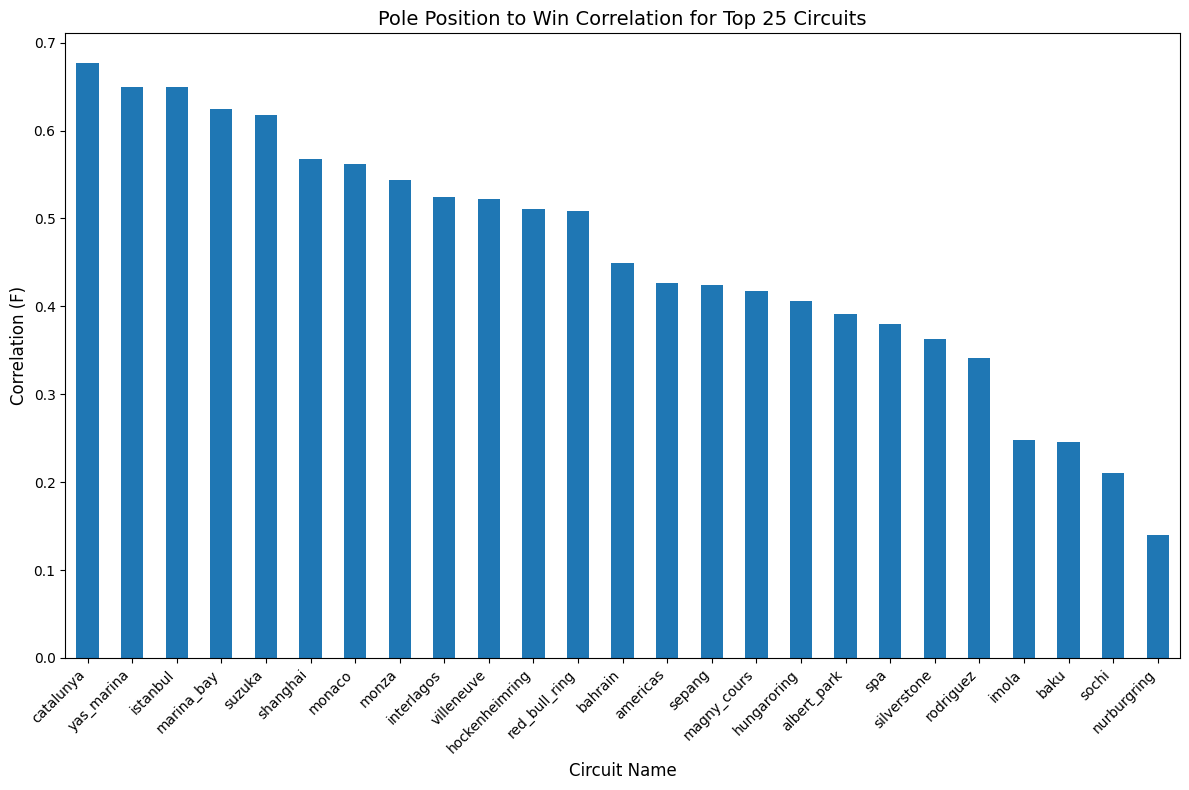

In [37]:
# Identify the 25 most popular circuits based on the number of races
top_circuits = merged_data['circuitId'].value_counts().head(25).index

# Filter the data for these circuits
filtered_data = merged_data[merged_data['circuitId'].isin(top_circuits)]

# Recalculate the correlation for these circuits
correlation_by_circuit = filtered_data.groupby('circuitId').apply(
    lambda x: x['grid'].eq(1).astype(int).corr(x['position'].eq(1).astype(int))
).sort_values(ascending=False)

# Get circuit names from the circuits data
circuit_names = circuits.set_index('circuitId')['circuitRef']

# Map circuit IDs to names for the x-axis
correlation_by_circuit.index = correlation_by_circuit.index.map(circuit_names)

# Plotting the correlation for the 15 most popular circuits
plt.figure(figsize=(12, 8))
correlation_by_circuit.plot(kind='bar')
plt.title('Pole Position to Win Correlation for Top 25 Circuits', fontsize=14)
plt.xlabel('Circuit Name', fontsize=12)
plt.ylabel('Correlation (F)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


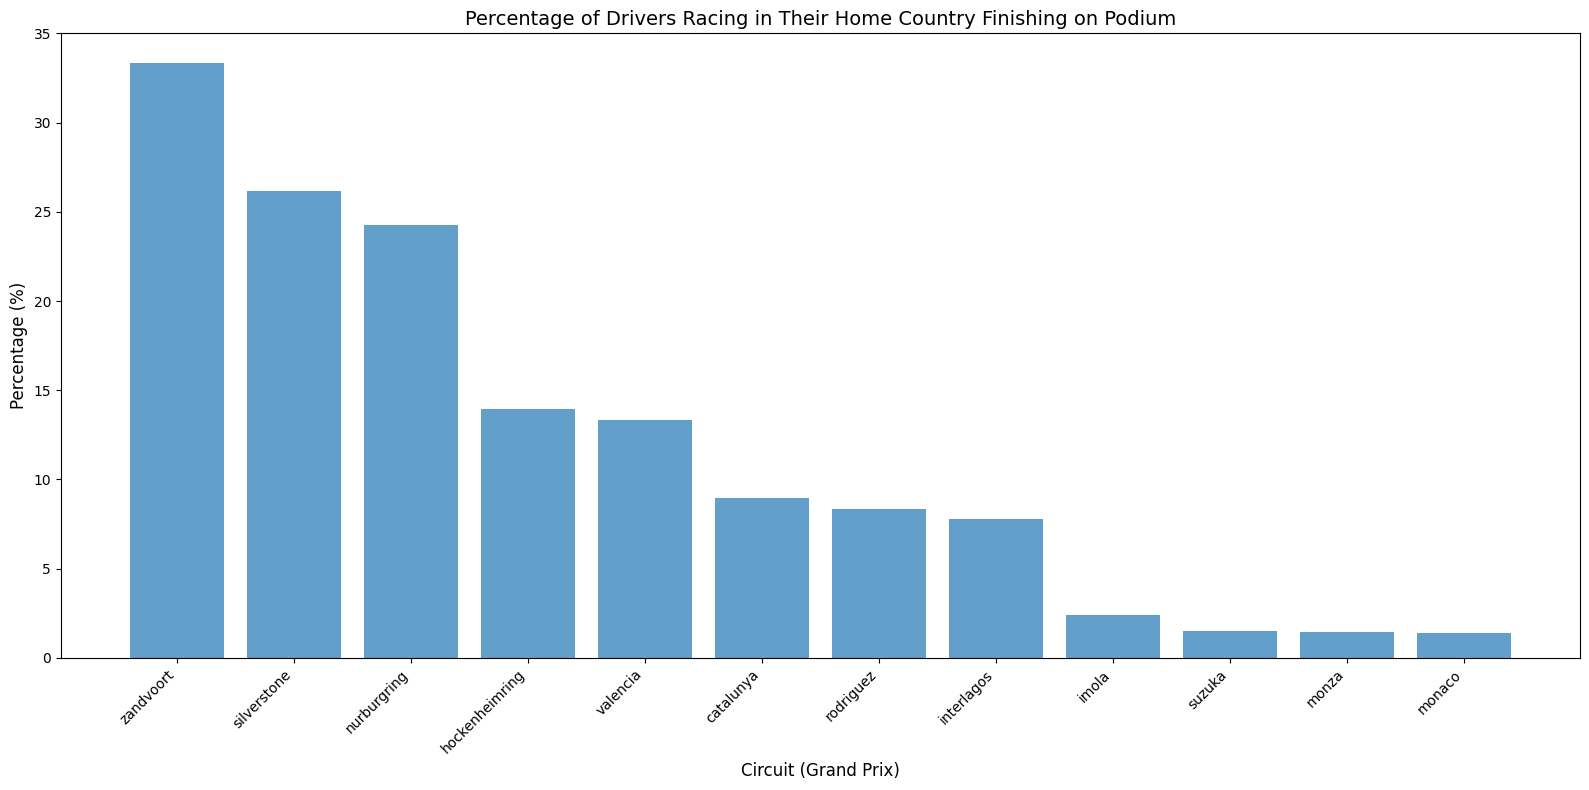

In [38]:
# Create a copy of cleaned_data
cleaned_data_df = merged_data.copy()


# Step 3: Add a column to indicate podium finishes
cleaned_data_df["on_podium"] = cleaned_data_df["position"].isin([1, 2, 3]).astype(int)

# Step 4: Calculate the percentage of podium finishes for drivers in their home country
podium_data = cleaned_data_df[cleaned_data_df["on_podium"] == 1]  # Filter podium data

# Group by circuitId and calculate the percentage of podium finishes for drivers in their home country
podium_home_circuit = (
    podium_data.apply(lambda x: x["country"] == x["driver_country"], axis=1)
    .groupby(podium_data["circuitId"])
    .mean()
    * 100
).sort_values(ascending=False)

# Merge with circuit information to get circuit names and countries
circuits_info = cleaned_data_df[["circuitId", "country", "circuitRef"]].drop_duplicates()
podium_home_circuit = podium_home_circuit.reset_index(name="percentage")
podium_home_circuit = podium_home_circuit.merge(circuits_info, on="circuitId", how="left")

# Filter to keep only circuits with percentage > 0
podium_home_circuit = podium_home_circuit[podium_home_circuit["percentage"] > 0]

# Sort by percentage and keep only necessary columns
podium_home_circuit = podium_home_circuit.sort_values(by="percentage", ascending=False)

# Plot the results
plt.figure(figsize=(16, 8))
plt.bar(
    podium_home_circuit["circuitRef"], podium_home_circuit["percentage"], alpha=0.7
)
plt.title("Percentage of Drivers Racing in Their Home Country Finishing on Podium", fontsize=14)
plt.xlabel("Circuit (Grand Prix)", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



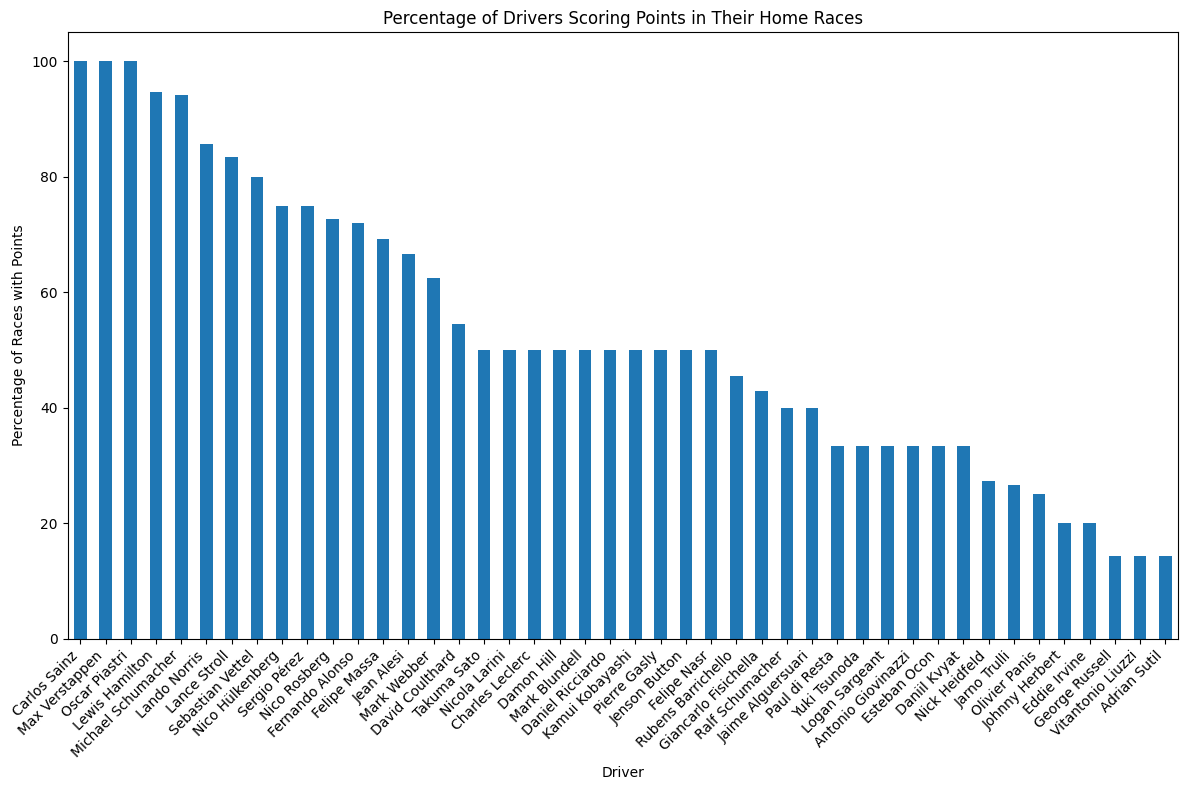

In [39]:
import matplotlib.pyplot as plt

# Filter data for drivers racing in their home country
home_race_data = cleaned_data_df[cleaned_data_df['country'] == cleaned_data_df['driver_country']]

# Calculate the percentage of races where drivers scored points in their home country
points_in_home_race = home_race_data[home_race_data['points'] > 0].groupby('driver_name').size()
total_home_races = home_race_data.groupby('driver_name').size()
points_percentage_home_race = (points_in_home_race / total_home_races) * 100

# Filter out drivers with 0% points
points_percentage_home_race = points_percentage_home_race[points_percentage_home_race > 0]

# Sort the results in descending order
points_percentage_home_race = points_percentage_home_race.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
points_percentage_home_race.plot(kind='bar')
plt.title('Percentage of Drivers Scoring Points in Their Home Races')
plt.xlabel('Driver')
plt.ylabel('Percentage of Races with Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

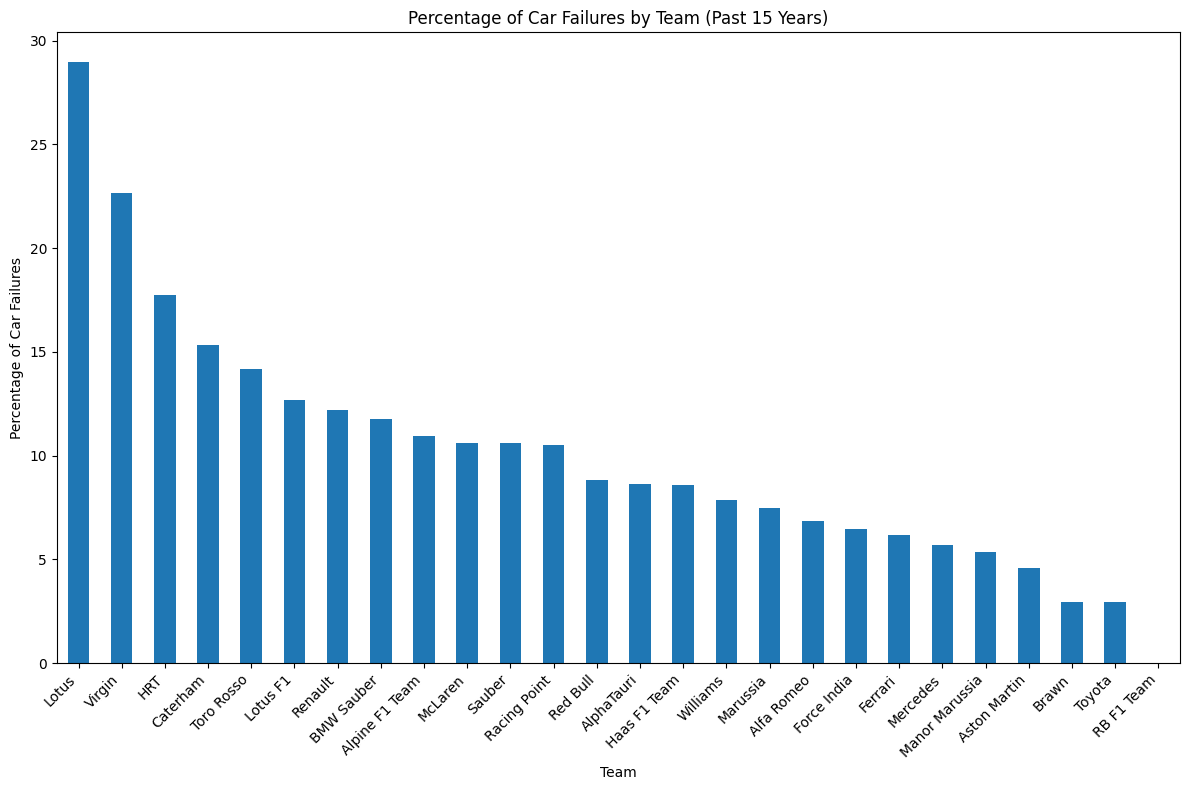

In [40]:
import matplotlib.pyplot as plt

# Filter data for the past 15 years
recent_years = merged_data[merged_data['year'] >= (merged_data['year'].max() - 15)]

# Calculate the total number of races for each team in the past 15 years
total_races_by_team_recent = recent_years['constructor_name'].value_counts()

# Calculate the number of failures for each team in the past 15 years
failures_by_team_recent = recent_years[recent_years['constructor_dnf'] == 1]['constructor_name'].value_counts()

# Calculate the percentage of failures
percentage_failures_by_team_recent = (failures_by_team_recent / total_races_by_team_recent) * 100

# Sort the results in descending order
percentage_failures_by_team_recent = percentage_failures_by_team_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_failures_by_team_recent.plot(kind='bar')
plt.title('Percentage of Car Failures by Team (Past 15 Years)')
plt.xlabel('Team')
plt.ylabel('Percentage of Car Failures')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

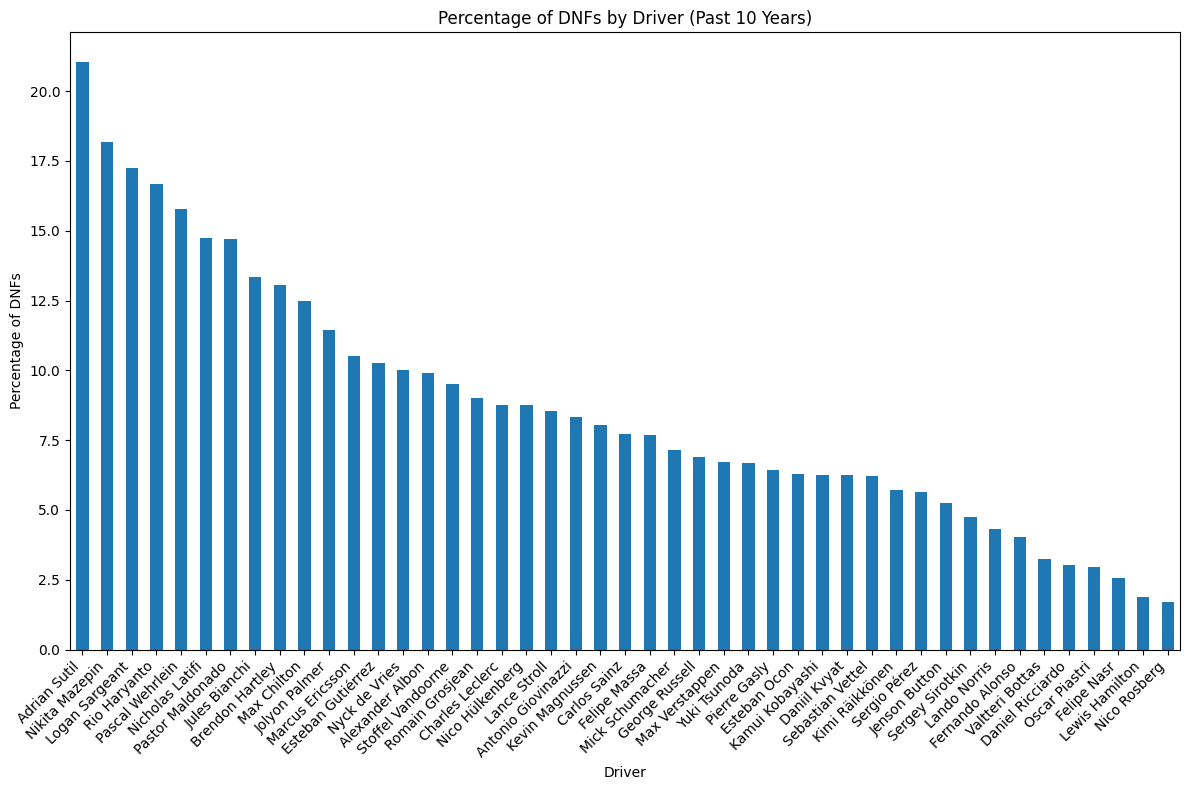

In [41]:
import matplotlib.pyplot as plt

# Filter data for the past 10 years
recent_years = merged_data[merged_data['year'] >= (merged_data['year'].max() - 10)]

# Calculate the total number of races for each driver in the past 10 years
total_races_by_driver_recent = recent_years['driver_name'].value_counts()

# Calculate the number of DNFs for each driver in the past 10 years
dnfs_by_driver_recent = recent_years[recent_years['driver_dnf'] == 1]['driver_name'].value_counts()

# Calculate the percentage of DNFs
percentage_dnfs_by_driver_recent = (dnfs_by_driver_recent / total_races_by_driver_recent) * 100

# Exclude drivers with 0 DNFs
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent[percentage_dnfs_by_driver_recent > 0]

# Sort the results in descending order
percentage_dnfs_by_driver_recent = percentage_dnfs_by_driver_recent.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
percentage_dnfs_by_driver_recent.plot(kind='bar')
plt.title('Percentage of DNFs by Driver (Past 10 Years)')
plt.xlabel('Driver')
plt.ylabel('Percentage of DNFs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\joelc\AppData\Local\Temp\ipykernel_8900\3859285042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25


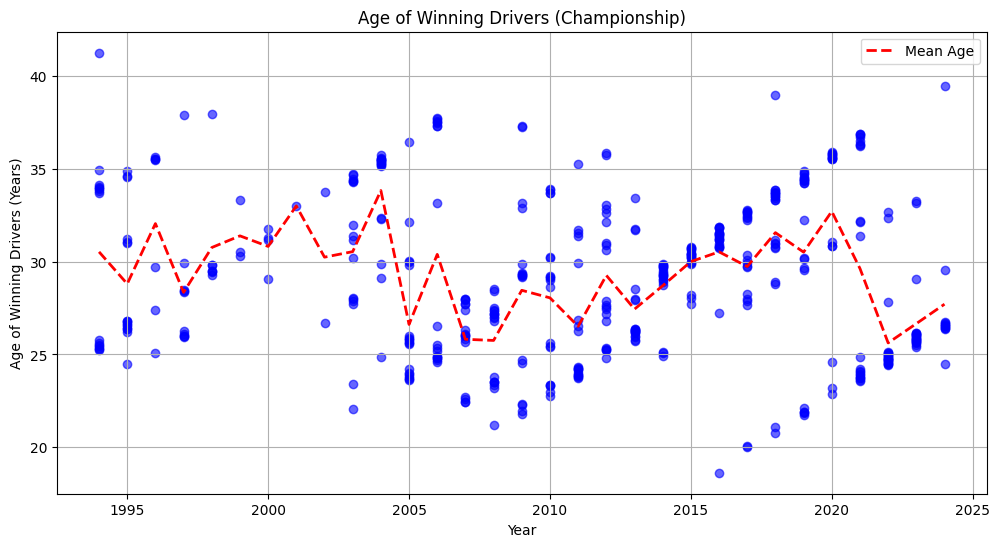

In [42]:
import matplotlib.pyplot as plt

# Filter data for winning drivers
winning_drivers = merged_data[merged_data['winner'] == 1]

# Calculate the age of the winning drivers in years
winning_drivers['age_at_gp_in_years'] = winning_drivers['age_at_gp_in_days'].astype(int) / 365.25

# Add a trending mean line
mean_age_per_year = winning_drivers.groupby('year')['age_at_gp_in_years'].mean()

plt.figure(figsize=(12, 6))
plt.scatter(winning_drivers['year'], winning_drivers['age_at_gp_in_years'], color='blue', alpha=0.6)
plt.plot(mean_age_per_year.index, mean_age_per_year.values, color='red', linestyle='--', linewidth=2, label='Mean Age')
plt.title('Age of Winning Drivers (Championship)')
plt.xlabel('Year')
plt.ylabel('Age of Winning Drivers (Years)')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
merged_data.to_csv('data/cleaned_data_EDA.csv', index=False)

### First training

initial prediction to evaluate the model's performance before proceeding with feature engineering and hyperparameter tuning.

Understanding the Problem
Objective: For each race, predict which driver will win (i.e., finish in position 1).
Constraints:
Only one driver can win each race.
Multiple drivers participate in each race.
Classification vs. Regression
Classification Problem:

Involves predicting a discrete class label.
Binary Classification: Predict whether each driver will win (1) or not (0).
Multiclass Classification: Not applicable here since only one driver wins per race.
Regression Problem:

Involves predicting a continuous value.
Predicting Positions: Could predict the finishing position of each driver (1st, 2nd, 3rd, etc.).
Answer: It's Primarily a Classification Problem with a Ranking Component
Classification:

Since the outcome (winning or not) is categorical, it's a classification problem.
However, due to the nature of the problem (only one winner per race), we need to handle it carefully.
Ranking Component:

We need to rank drivers within each race to predict the most likely winner.
This adds a layer of complexity beyond simple binary classification.
How to Proceed
1. Set Up the Problem as a Classification Task
Goal: For each driver in each race, predict the probability of winning.
Target Variable: winner (1 if the driver won the race, 0 otherwise).
2. Address the Unique Challenge
Constraint: Only one driver can win per race.
Implication: Traditional classification might predict multiple winners per race, which isn't realistic.
3. Implement a Per-Race Winner Selection
Solution: For each race, after predicting probabilities, select the driver with the highest probability as the predicted winner.
This ensures that only one driver is predicted as the winner per race.

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Read the data with error handling

data = pd.read_csv('data/cleaned_data_EDA.csv')
print(data.head())


   raceId  year  round  circuitId               GP_name        date  \
0     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
1     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
2     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
3     257  1994      1         18  Brazilian Grand Prix  1994-03-27   
4     257  1994      1         18  Brazilian Grand Prix  1994-03-27   

   circuitRef country  grid  position  ...  championship_position  \
0  interlagos  Brazil     2         1  ...                      1   
1  interlagos  Brazil     9        13  ...                     16   
2  interlagos  Brazil     4         2  ...                      2   
3  interlagos  Brazil     1        13  ...                     13   
4  interlagos  Brazil     8        13  ...                     21   

   number_wins driver_dnf constructor_dnf         driver_name  \
0            1          0               0  Michael Schumacher   
1            0          1   

In [45]:
# Check data types
print(data.dtypes)

raceId                     int64
year                       int64
round                      int64
circuitId                  int64
GP_name                   object
date                      object
circuitRef                object
country                   object
grid                       int64
position                   int64
points                   float64
laps                       int64
dob                       object
constructor_name          object
total_points             float64
championship_position      int64
number_wins                int64
driver_dnf                 int64
constructor_dnf            int64
driver_name               object
age_at_gp_in_days          int64
driver_country            object
constructor_country       object
winner                     int64
q1_seconds               float64
dtype: object


In [46]:
data.columns

Index(['raceId', 'year', 'round', 'circuitId', 'GP_name', 'date', 'circuitRef',
       'country', 'grid', 'position', 'points', 'laps', 'dob',
       'constructor_name', 'total_points', 'championship_position',
       'number_wins', 'driver_dnf', 'constructor_dnf', 'driver_name',
       'age_at_gp_in_days', 'driver_country', 'constructor_country', 'winner',
       'q1_seconds'],
      dtype='object')

In [47]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')


# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round', 
    'number_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'year'

]

target = 'winner'

# Subset the data
df = data[features + ['raceId', target]].copy()


# Define categorical and numerical features
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year']
numerical_features_unscaled = [
    'grid', 'total_points', 'championship_position', 'number_wins', 'round'
]

# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

# Prepare training data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data
X_test = test_df[features]
y_test = test_df[target]
race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Function to calculate race-wise accuracy
def calculate_race_wise_accuracy(y_true, y_probs, race_ids, driver_names):
    # Create a DataFrame with the necessary information
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'driver_name': driver_names,
        'winner': y_true,
        'predicted_prob': y_probs
    })

    # Get unique races
    unique_races = results_df['raceId'].unique()
    
    correct_predictions = 0
    total_races = len(unique_races)

    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id]
        # Predict the winner as the driver with the highest predicted probability
        predicted_winner = race_data.loc[race_data['predicted_prob'].idxmax()]
        actual_winner = race_data[race_data['winner'] == 1]
        if not actual_winner.empty:
            actual_winner_name = actual_winner['driver_name'].values[0]
            if predicted_winner['driver_name'] == actual_winner_name:
                correct_predictions += 1
        else:
            # Handle cases where there is no actual winner in the data
            total_races -= 1  # Exclude this race from total count
    if total_races > 0:
        race_wise_accuracy = correct_predictions / total_races
    else:
        race_wise_accuracy = 0
    return race_wise_accuracy

# Create a function to perform cross-validation and calculate mean race-wise accuracy
def cross_validate_race_wise(model, X, y, df, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    race_wise_accuracies = []

    for train_index, val_index in tscv.split(X):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]
        df_val_fold = df.iloc[val_index].reset_index(drop=True)
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities on validation set
        y_probs = pipeline.predict_proba(X_val_fold)[:, 1]
        
        # Calculate race-wise accuracy
        race_wise_acc = calculate_race_wise_accuracy(
            y_true=y_val_fold.reset_index(drop=True),
            y_probs=y_probs,
            race_ids=df_val_fold['raceId'],
            driver_names=df_val_fold['driver_name']
        )
        race_wise_accuracies.append(race_wise_acc)

    mean_race_wise_accuracy = np.mean(race_wise_accuracies)
    return mean_race_wise_accuracy

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Adjust scale_pos_weight for XGBoost
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
models['XGBoost'].set_params(scale_pos_weight=ratio)

# Store results
results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    # Cross-validation on training data
    mean_race_wise_accuracy = cross_validate_race_wise(model, X_train, y_train, train_df, n_splits=5)
    
    # Fit the model on the entire training data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on test data
    y_probs_test = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate race-wise accuracy on test set
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Store the results
    results[model_name] = {
        'mean_race_wise_accuracy_train': mean_race_wise_accuracy,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }

# Print summary of results
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")


Processing Logistic Regression...
Processing Random Forest...
Processing SVM...
Processing XGBoost...

Summary of Results:
Logistic Regression:
 - Mean Race-wise Accuracy on training data: 0.5671
 - Race-wise Accuracy on test data: 0.7053

Random Forest:
 - Mean Race-wise Accuracy on training data: 0.5335
 - Race-wise Accuracy on test data: 0.6947

SVM:
 - Mean Race-wise Accuracy on training data: 0.4853
 - Race-wise Accuracy on test data: 0.5684

XGBoost:
 - Mean Race-wise Accuracy on training data: 0.5527
 - Race-wise Accuracy on test data: 0.6421



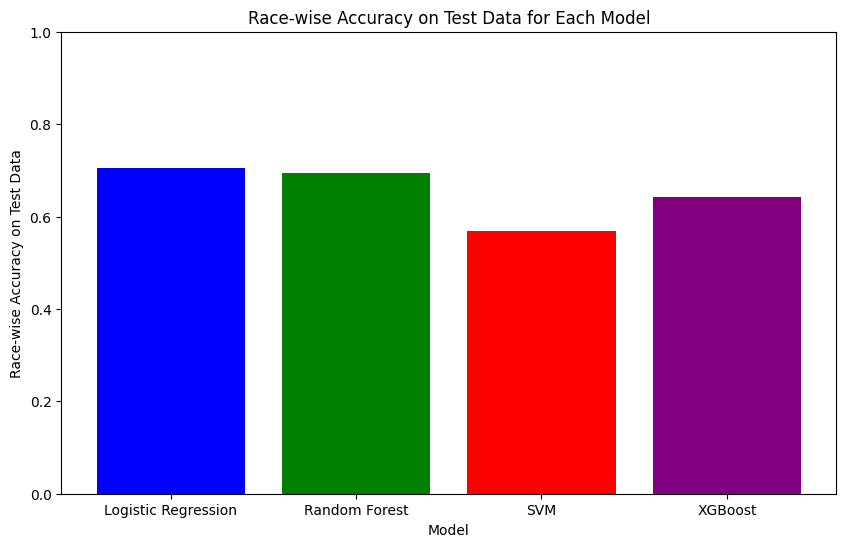

In [48]:
import matplotlib.pyplot as plt

# Extract race-wise accuracy on test data for each model
model_names = list(results.keys())
race_wise_accuracies = [results[model]['race_wise_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, race_wise_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Race-wise Accuracy on Test Data')
plt.title('Race-wise Accuracy on Test Data for Each Model')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

### FEATURE ENGINEERING

new features: 
- constructor reliability
- driver reliability
- driver home race
- constructor hom race
- average performance last 3 races

In [97]:
def calculate_constructor_reliability(df):
    # Calculate total races participated by each constructor
    constructor_total_races = df.groupby('constructor_name')['raceId'].nunique().reset_index()
    constructor_total_races.rename(columns={'raceId': 'constructor_total_races'}, inplace=True)
    
    # Calculate total DNFs for each constructor
    constructor_total_dnfs = df.groupby('constructor_name')['constructor_dnf'].sum().reset_index()
    constructor_total_dnfs.rename(columns={'constructor_dnf': 'constructor_total_dnfs'}, inplace=True)
    
    # Merge the two DataFrames
    constructor_reliability = pd.merge(constructor_total_races, constructor_total_dnfs, on='constructor_name')
    
    # Calculate constructor reliability
    constructor_reliability['constructor_reliability'] = 1 - (constructor_reliability['constructor_total_dnfs'] / constructor_reliability['constructor_total_races'])
    
    # Keep only the necessary columns
    constructor_reliability = constructor_reliability[['constructor_name', 'constructor_reliability']]
    
    # Merge back to the original DataFrame
    df = df.merge(constructor_reliability, on='constructor_name', how='left')
    
    return df

def calculate_driver_reliability(df):
    # Calculate total races participated by each driver
    driver_total_races = df.groupby('driver_name')['raceId'].nunique().reset_index()
    driver_total_races.rename(columns={'raceId': 'driver_total_races'}, inplace=True)
    
    # Calculate total DNFs for each driver
    driver_total_dnfs = df.groupby('driver_name')['driver_dnf'].sum().reset_index()
    driver_total_dnfs.rename(columns={'driver_dnf': 'driver_total_dnfs'}, inplace=True)
    
    # Merge the two DataFrames
    driver_reliability = pd.merge(driver_total_races, driver_total_dnfs, on='driver_name')
    
    # Calculate driver reliability
    driver_reliability['driver_reliability'] = 1 - (driver_reliability['driver_total_dnfs'] / driver_reliability['driver_total_races'])
    
    # Keep only the necessary columns
    driver_reliability = driver_reliability[['driver_name', 'driver_reliability']]
    
    # Merge back to the original DataFrame
    df = df.merge(driver_reliability, on='driver_name', how='left')
    
    return df

def add_driver_home_race(df):
    df['driver_home_race'] = (df['driver_country'] == df['country']).astype(int)
    return df

def add_constructor_home_race(df):
    df['constructor_home_race'] = (df['constructor_country'] == df['country']).astype(int)
    return df

def avg_performance_3(df):
    """
    Calculate and add the average performance on the last 5 races per driver to the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing race data.
    
    Returns:
    pd.DataFrame: The DataFrame with the added average performance column.
    """
    # Sort the DataFrame by driver_name and date
    df = df.sort_values(by=['driver_name', 'date'])
    
    # Calculate the average performance on the last 5 races for each driver
    df['avg_performance_3'] = df.groupby('driver_name')['position'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    
    return df


In [ ]:
# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')

data['date'] = pd.to_datetime(data['date'])


# Implement the new features
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)
data = avg_performance_3(data)

# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round',
    'number_wins', 'driver_country', 'constructor_name', 'country','constructor_country', 'driver_name', 'year',
    # New features
    'constructor_reliability', 'driver_reliability', 'driver_home_race','constructor_home_race', 'avg_performance_3']

target = 'winner'

# Subset the data
df = data[features + ['raceId', target]].copy()
df = df.dropna(subset=features + [target])

# Define categorical and numerical features
# Update numerical and categorical features
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year', 'avg_performance_3']
numerical_features_unscaled = [
    'grid', 'total_points', 'championship_position', 'number_wins',  'driver_home_race', 'round',
    'constructor_home_race', 'constructor_reliability', 'driver_reliability']
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']


# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

# Prepare training data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data
X_test = test_df[features]
y_test = test_df[target]
race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


# Function to calculate race-wise accuracy
def calculate_race_wise_accuracy(y_true, y_probs, race_ids, driver_names):
    # Create a DataFrame with the necessary information
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'driver_name': driver_names,
        'winner': y_true,
        'predicted_prob': y_probs
    })

    # Get unique races
    unique_races = results_df['raceId'].unique()
    
    correct_predictions = 0
    total_races = len(unique_races)

    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id]
        # Predict the winner as the driver with the highest predicted probability
        predicted_winner = race_data.loc[race_data['predicted_prob'].idxmax()]
        actual_winner = race_data[race_data['winner'] == 1]
        if not actual_winner.empty:
            actual_winner_name = actual_winner['driver_name'].values[0]
            if predicted_winner['driver_name'] == actual_winner_name:
                correct_predictions += 1
        else:
            # Handle cases where there is no actual winner in the data
            total_races -= 1  # Exclude this race from total count
    if total_races > 0:
        race_wise_accuracy = correct_predictions / total_races
    else:
        race_wise_accuracy = 0
    return race_wise_accuracy

# Create a function to perform cross-validation and calculate mean race-wise accuracy
def cross_validate_race_wise(model, X, y, df, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    race_wise_accuracies = []

    for train_index, val_index in tscv.split(X):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]
        df_val_fold = df.iloc[val_index].reset_index(drop=True)
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities on validation set
        y_probs = pipeline.predict_proba(X_val_fold)[:, 1]
        
        # Calculate race-wise accuracy
        race_wise_acc = calculate_race_wise_accuracy(
            y_true=y_val_fold.reset_index(drop=True),
            y_probs=y_probs,
            race_ids=df_val_fold['raceId'],
            driver_names=df_val_fold['driver_name']
        )
        race_wise_accuracies.append(race_wise_acc)

    mean_race_wise_accuracy = np.mean(race_wise_accuracies)
    return mean_race_wise_accuracy

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Adjust scale_pos_weight for XGBoost
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
models['XGBoost'].set_params(scale_pos_weight=ratio)

# Store results
results = {}

for model_name, model in models.items():
    print(f"Processing {model_name}...")
    # Cross-validation on training data
    mean_race_wise_accuracy = cross_validate_race_wise(model, X_train, y_train, train_df, n_splits=5)
    
    # Fit the model on the entire training data
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities on test data
    y_probs_test = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate race-wise accuracy on test set
    test_race_wise_accuracy = calculate_race_wise_accuracy(
        y_true=y_test.reset_index(drop=True),
        y_probs=y_probs_test,
        race_ids=race_ids_test.reset_index(drop=True),
        driver_names=driver_names_test.reset_index(drop=True)
    )
    
    # Store the results
    results[model_name] = {
        'mean_race_wise_accuracy_train': mean_race_wise_accuracy,
        'race_wise_accuracy_test': test_race_wise_accuracy
    }
    

# Print summary of results
print("\nSummary of Results:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f" - Mean Race-wise Accuracy on training data: {metrics['mean_race_wise_accuracy_train']:.4f}")
    print(f" - Race-wise Accuracy on test data: {metrics['race_wise_accuracy_test']:.4f}\n")

Processing Logistic Regression...
Saved actual vs. predicted winners to Logistic Regression_winners_comparison.csv
Processing Random Forest...
Saved actual vs. predicted winners to Random Forest_winners_comparison.csv
Processing SVM...
Saved actual vs. predicted winners to SVM_winners_comparison.csv
Processing XGBoost...
Saved actual vs. predicted winners to XGBoost_winners_comparison.csv

Summary of Results:
Logistic Regression:
 - Mean Race-wise Accuracy on training data: 0.8609
 - Race-wise Accuracy on test data: 0.6842

Random Forest:
 - Mean Race-wise Accuracy on training data: 0.9146
 - Race-wise Accuracy on test data: 0.7368

SVM:
 - Mean Race-wise Accuracy on training data: 0.8681
 - Race-wise Accuracy on test data: 0.5789

XGBoost:
 - Mean Race-wise Accuracy on training data: 0.9096
 - Race-wise Accuracy on test data: 0.7684



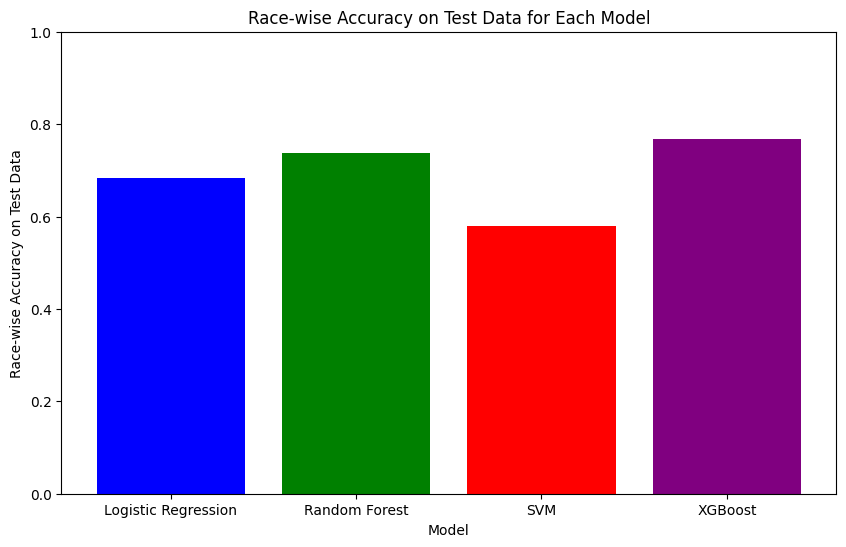

In [107]:
import matplotlib.pyplot as plt

# Extract race-wise accuracy on test data for each model
model_names = list(results.keys())
race_wise_accuracies = [results[model]['race_wise_accuracy_test'] for model in model_names]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, race_wise_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Race-wise Accuracy on Test Data')
plt.title('Race-wise Accuracy on Test Data for Each Model')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

In [75]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Logistic Regression with RFECV
logistic = LogisticRegression(max_iter=1000, class_weight='balanced')
rfecv = RFECV(estimator=logistic, cv=5, scoring= 'accuracy') 
pipeline_rfecv = Pipeline(steps=[ 
    ('preprocessor', preprocessor),
    ('feature_selection', rfecv),
    ('classifier', logistic)
])
pipeline_rfecv.fit(X_train, y_train)

# Selected features
selected_features_rfecv = rfecv.support_
selected_feature_names_rfecv = [f for f, selected in zip(features, selected_features_rfecv) if selected]
print("Selected Features for Logistic Regression with RFECV:", selected_feature_names_rfecv)


Selected Features for Logistic Regression with RFECV: ['grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round', 'number_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'year', 'constructor_reliability', 'driver_reliability', 'driver_home_race', 'constructor_home_race', 'avg_performance_3']


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Define the SVM model
svm_model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)

# Define the RFE with SVM
rfe = RFE(estimator=svm_model, n_features_to_select=10)  # Adjust the number of features to select

# Create a pipeline with preprocessing and RFE
pipeline_rfe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('classifier', svm_model)
])

# Fit the pipeline on the training data
pipeline_rfe.fit(X_train, y_train)

# Get the selected features
selected_features_rfe = rfe.support_
selected_feature_names_rfe = [f for f, selected in zip(features, selected_features_rfe) if selected]

print("Selected Features for SVM with RFE:", selected_feature_names_rfe)

Selected Features for Logistic Regression with RFECV: ['grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round', 'number_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'year', 'constructor_reliability', 'driver_reliability', 'driver_home_race', 'constructor_home_race']

Selected Features for Random Forest: ['grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round', 'driver_country', 'country', 'constructor_country']

Selected Features for XGBoost: ['grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round', 'number_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'year', 'driver_home_race']


In [76]:
from sklearn.feature_selection import SelectFromModel

# Random Forest Feature Importances
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
sfm = SelectFromModel(estimator=rf, threshold="mean")  # Select features above mean importance
pipeline_sfm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', sfm),
    ('classifier', rf)
])
pipeline_sfm.fit(X_train, y_train)

# Selected features
selected_features_rf = sfm.get_support()
selected_feature_names_rf = [f for f, selected in zip(features, selected_features_rf) if selected]
print("Selected Features for Random Forest:", selected_feature_names_rf)


Selected Features for Random Forest: ['grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round', 'number_wins', 'constructor_name', 'constructor_country', 'driver_name']


In [77]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
sfm_xgb = SelectFromModel(estimator=xgb, threshold="mean")
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', sfm_xgb),
    ('classifier', xgb)
])
pipeline_xgb.fit(X_train, y_train)

# Selected features
selected_features_xgb = sfm_xgb.get_support()
selected_feature_names_xgb = [f for f, selected in zip(features, selected_features_xgb) if selected]
print("Selected Features for XGBoost:", selected_feature_names_xgb)


Selected Features for XGBoost: ['grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round', 'number_wins', 'driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'constructor_reliability', 'constructor_home_race']


In [78]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, f_classif

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------------------------

# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')
data['date'] = pd.to_datetime(data['date'])

# Implement the new features
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)
data = avg_performance_3(data)

# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round',
    'number_wins', 'driver_country', 'constructor_name', 'country','constructor_country', 'driver_name', 'year',
    # New features
    'constructor_reliability', 'driver_reliability', 'driver_home_race','constructor_home_race', 'avg_performance_3'
]

target = 'winner'

# Subset the data
df = data[features + ['raceId', target]].copy()
df = df.dropna(subset=features + [target])

# Define categorical and numerical features
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year', 'avg_performance_3']
numerical_features_unscaled = [
    'grid', 'total_points', 'championship_position', 'number_wins',  'driver_home_race', 'round',
    'constructor_home_race', 'constructor_reliability', 'driver_reliability'
]
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']

# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

# Prepare training data
X_train = train_df[features]
y_train = train_df[target]

# Prepare test data
X_test = test_df[features]
y_test = test_df[target]
race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Function to calculate race-wise accuracy
def calculate_race_wise_accuracy(y_true, y_probs, race_ids, driver_names):
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'driver_name': driver_names,
        'winner': y_true,
        'predicted_prob': y_probs
    })

    unique_races = results_df['raceId'].unique()
    correct_predictions = 0
    total_races = len(unique_races)

    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id]
        if race_data.empty:
            continue  # Skip if no data for race_id

        # Predict the winner as the driver with the highest predicted probability
        predicted_winner = race_data.loc[race_data['predicted_prob'].idxmax()]
        actual_winner = race_data[race_data['winner'] == 1]
        if not actual_winner.empty:
            actual_winner_name = actual_winner['driver_name'].values[0]
            if predicted_winner['driver_name'] == actual_winner_name:
                correct_predictions += 1
        else:
            total_races -= 1  # Exclude this race from total count

    if total_races > 0:
        race_wise_accuracy = correct_predictions / total_races
    else:
        race_wise_accuracy = 0
    return race_wise_accuracy

# Define Feature Selection Methods
feature_selection_methods = {
    'None': 'passthrough',  # No feature selection
    'SelectFromModel_RF': SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median'),
    'RFE_LR': RFE(estimator=LogisticRegression(max_iter=1000, class_weight='balanced'), n_features_to_select=10),
    'SelectKBest_ANOVA': SelectKBest(f_classif, k=20)
}

# Define Models and their Parameter Grids
models_and_params = {
    'Logistic Regression': (
        LogisticRegression(max_iter=1000, class_weight='balanced'),
        {
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__penalty': ['l2', 'none'],
            'classifier__solver': ['lbfgs', 'saga']
        }
    ),
    'Random Forest': (
        RandomForestClassifier(class_weight='balanced', random_state=42),
        {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10],
            'classifier__min_samples_split': [2, 5]
        }
    ),
    'SVM': (
        SVC(probability=True, class_weight='balanced', random_state=42),
        {
            'classifier__C': [0.1, 1],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    ),
    'XGBoost': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.01, 0.1]
        }
    )
}

# Adjust scale_pos_weight for XGBoost
ratio = (len(y_train) - sum(y_train)) / sum(y_train)
models_and_params['XGBoost'][0].set_params(scale_pos_weight=ratio)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Store results
tuning_results = {}

# Iterate over Feature Selection Methods
for fs_name, fs_method in feature_selection_methods.items():
    print(f"\n=== Feature Selection Method: {fs_name} ===")
    
    # Iterate over Models
    for model_name, (model, param_grid) in models_and_params.items():
        print(f"Tuning hyperparameters for {model_name} with {fs_name}...")
        
        # Create Pipeline with Feature Selection
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('feature_selection', fs_method),
            ('classifier', model)
        ])
        
        # Define Parameter Grid for the Pipeline
        # Prefix parameters with 'feature_selection__' if applicable
        if fs_name != 'None':
            # Example: For SelectFromModel_RF and SelectKBest_ANOVA, you might want to tune additional parameters
            # Here, we keep it simple by only tuning classifier parameters
            grid = param_grid
        else:
            grid = param_grid  # No feature selection parameters
        
        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=grid,
            scoring='roc_auc',  # Use standard metric
            cv=tscv,
            n_jobs=-1,
            verbose=0
        )
        
        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)
        
        # Best model after tuning
        best_model = grid_search.best_estimator_
        
        # Evaluate on test data
        y_probs_test = best_model.predict_proba(X_test)[:, 1]
        test_race_wise_accuracy = calculate_race_wise_accuracy(
            y_test.reset_index(drop=True),
            y_probs_test,
            race_ids_test.reset_index(drop=True),
            driver_names_test.reset_index(drop=True)
        )
        
        # Extract Best Parameters
        best_params = grid_search.best_params_
        
        # Store the results
        key = (fs_name, model_name)
        tuning_results[key] = {
            'best_params': best_params,
            'best_cv_roc_auc': grid_search.best_score_,
            'test_race_wise_accuracy': test_race_wise_accuracy
        }
        
        # Print Progress
        print(f"Completed {model_name} with {fs_name}.")
    
    print(f"Completed Feature Selection Method: {fs_name}")

# Print summary of hyperparameter tuning results
print("\n=== Summary of Hyperparameter Tuning Results ===\n")
for (fs_name, model_name), metrics in tuning_results.items():
    print(f"Feature Selection: {fs_name} | Model: {model_name}")
    print(f" - Best Params: {metrics['best_params']}")
    print(f" - Best CV ROC-AUC Score: {metrics['best_cv_roc_auc']:.4f}")
    print(f" - Test Race-wise Accuracy: {metrics['test_race_wise_accuracy']:.4f}\n")

# Optional: Identify the Best Overall Model based on Test Race-wise Accuracy
best_overall = max(tuning_results.items(), key=lambda x: x[1]['test_race_wise_accuracy'])
best_fs, best_model_name = best_overall[0]
best_accuracy = best_overall[1]['test_race_wise_accuracy']

print(f"=== Best Overall Model ===")
print(f"Feature Selection: {best_fs} | Model: {best_model_name}")
print(f" - Test Race-wise Accuracy: {best_accuracy:.4f}")

# ----------------------------------------------------------
# Retrieve and Display Selected Features for the Best Model
print("\n=== Selected Features for the Best Model ===")
best_pipeline = best_overall[1]['best_params']
# Refit the best pipeline to extract features
# Note: This assumes that the best model parameters are already set in best_model
# So, we can use best_model directly

# Extract the preprocessor and feature selection steps
preprocessor_step = best_model.named_steps['preprocessor']
feature_selector_step = best_model.named_steps['feature_selection']

# Get the transformed feature names from the preprocessor
# Numerical features
num_scaled_features = numerical_features_to_scale
num_unscaled_features = numerical_features_unscaled

# Get categorical feature names after one-hot encoding
cat_features_encoded = preprocessor_step.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine them in the order they appear in the pipeline
final_feature_names = (
    num_scaled_features + 
    numerical_features_unscaled + 
    list(cat_features_encoded)
)

# If feature selection is not 'None', get the selected features
if fs_name != 'None':
    selected_mask = feature_selector_step.get_support()
    selected_feature_names = [f for f, s in zip(final_feature_names, selected_mask) if s]
else:
    selected_feature_names = final_feature_names

print(selected_feature_names)



=== Feature Selection Method: None ===
Tuning hyperparameters for Logistic Regression with None...
Completed Logistic Regression with None.
Tuning hyperparameters for Random Forest with None...
Completed Random Forest with None.
Tuning hyperparameters for SVM with None...
Completed SVM with None.
Tuning hyperparameters for XGBoost with None...
Completed XGBoost with None.
Completed Feature Selection Method: None

=== Feature Selection Method: SelectFromModel_RF ===
Tuning hyperparameters for Logistic Regression with SelectFromModel_RF...
Completed Logistic Regression with SelectFromModel_RF.
Tuning hyperparameters for Random Forest with SelectFromModel_RF...
Completed Random Forest with SelectFromModel_RF.
Tuning hyperparameters for SVM with SelectFromModel_RF...
Completed SVM with SelectFromModel_RF.
Tuning hyperparameters for XGBoost with SelectFromModel_RF...
Completed XGBoost with SelectFromModel_RF.
Completed Feature Selection Method: SelectFromModel_RF

=== Feature Selection Met

### INSIGHTS:

resultats:

=== Feature Selection Method: None ===
Tuning hyperparameters for Logistic Regression with None...
Completed Logistic Regression with None.
Tuning hyperparameters for Random Forest with None...
Completed Random Forest with None.
Tuning hyperparameters for SVM with None...
Completed SVM with None.
Tuning hyperparameters for XGBoost with None...
Completed XGBoost with None.
Completed Feature Selection Method: None

=== Feature Selection Method: SelectFromModel_RF ===
Tuning hyperparameters for Logistic Regression with SelectFromModel_RF...
Completed Logistic Regression with SelectFromModel_RF.
Tuning hyperparameters for Random Forest with SelectFromModel_RF...
Completed Random Forest with SelectFromModel_RF.
Tuning hyperparameters for SVM with SelectFromModel_RF...
Completed SVM with SelectFromModel_RF.
Tuning hyperparameters for XGBoost with SelectFromModel_RF...
Completed XGBoost with SelectFromModel_RF.
Completed Feature Selection Method: SelectFromModel_RF

=== Feature Selection Method: RFE_LR ===
Tuning hyperparameters for Logistic Regression with RFE_LR...
Completed Logistic Regression with RFE_LR.
Tuning hyperparameters for Random Forest with RFE_LR...
Completed Random Forest with RFE_LR.
Tuning hyperparameters for SVM with RFE_LR...
Completed SVM with RFE_LR.
Tuning hyperparameters for XGBoost with RFE_LR...
Completed XGBoost with RFE_LR.
Completed Feature Selection Method: RFE_LR

=== Feature Selection Method: SelectKBest_ANOVA ===
Tuning hyperparameters for Logistic Regression with SelectKBest_ANOVA...
Completed Logistic Regression with SelectKBest_ANOVA.
Tuning hyperparameters for Random Forest with SelectKBest_ANOVA...
Completed Random Forest with SelectKBest_ANOVA.
Tuning hyperparameters for SVM with SelectKBest_ANOVA...
Completed SVM with SelectKBest_ANOVA.
Tuning hyperparameters for XGBoost with SelectKBest_ANOVA...
Completed XGBoost with SelectKBest_ANOVA.
Completed Feature Selection Method: SelectKBest_ANOVA

=== Summary of Hyperparameter Tuning Results ===

Feature Selection: None | Model: Logistic Regression
 - Best Params: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
 - Best CV ROC-AUC Score: 0.9565
 - Test Race-wise Accuracy: 0.6947

Feature Selection: None | Model: Random Forest
 - Best Params: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
 - Best CV ROC-AUC Score: 0.9645
 - Test Race-wise Accuracy: 0.7053

Feature Selection: None | Model: SVM
 - Best Params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
 - Best CV ROC-AUC Score: 0.9513
 - Test Race-wise Accuracy: 0.7053

Feature Selection: None | Model: XGBoost
 - Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
 - Best CV ROC-AUC Score: 0.9715
 - Test Race-wise Accuracy: 0.7263

Feature Selection: SelectFromModel_RF | Model: Logistic Regression
 - Best Params: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
 - Best CV ROC-AUC Score: 0.9571
 - Test Race-wise Accuracy: 0.7053

Feature Selection: SelectFromModel_RF | Model: Random Forest
 - Best Params: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
 - Best CV ROC-AUC Score: 0.9652
 - Test Race-wise Accuracy: 0.7263

Feature Selection: SelectFromModel_RF | Model: SVM
 - Best Params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
 - Best CV ROC-AUC Score: 0.9514
 - Test Race-wise Accuracy: 0.7053

Feature Selection: SelectFromModel_RF | Model: XGBoost
 - Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
 - Best CV ROC-AUC Score: 0.9715
 - Test Race-wise Accuracy: 0.7263

Feature Selection: RFE_LR | Model: Logistic Regression
 - Best Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
 - Best CV ROC-AUC Score: 0.8285
 - Test Race-wise Accuracy: 0.6211

Feature Selection: RFE_LR | Model: Random Forest
 - Best Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
 - Best CV ROC-AUC Score: 0.8232
 - Test Race-wise Accuracy: 0.6316

Feature Selection: RFE_LR | Model: SVM
 - Best Params: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
 - Best CV ROC-AUC Score: 0.8300
 - Test Race-wise Accuracy: 0.6211

Feature Selection: RFE_LR | Model: XGBoost
 - Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
 - Best CV ROC-AUC Score: 0.8266
 - Test Race-wise Accuracy: 0.6316

Feature Selection: SelectKBest_ANOVA | Model: Logistic Regression
 - Best Params: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
 - Best CV ROC-AUC Score: 0.9583
 - Test Race-wise Accuracy: 0.7053

Feature Selection: SelectKBest_ANOVA | Model: Random Forest
 - Best Params: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
 - Best CV ROC-AUC Score: 0.9687
 - Test Race-wise Accuracy: 0.7263

Feature Selection: SelectKBest_ANOVA | Model: SVM
 - Best Params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
 - Best CV ROC-AUC Score: 0.9561
 - Test Race-wise Accuracy: 0.7053

Feature Selection: SelectKBest_ANOVA | Model: XGBoost
 - Best Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
 - Best CV ROC-AUC Score: 0.9717
 - Test Race-wise Accuracy: 0.7684

=== Best Overall Model ===
Feature Selection: SelectKBest_ANOVA | Model: XGBoost
 - Test Race-wise Accuracy: 0.7684

=== Selected Features for the Best Model ===
['avg_performance_3', 'grid', 'total_points', 'championship_position', 'number_wins', 'constructor_reliability', 'driver_reliability', 'driver_country_Germany', 'driver_country_UK', 'constructor_name_Benetton', 'constructor_name_Ferrari', 'constructor_name_Mercedes', 'constructor_name_Red Bull', 'constructor_country_Austria', 'constructor_country_Germany', 'constructor_country_Switzerland', 'driver_name_Damon Hill', 'driver_name_Lewis Hamilton', 'driver_name_Michael Schumacher', 'driver_name_Sebastian Vettel']

Després de fer feature selection and hyperparameter tunning veiem que el millor model és xgboost amb una race-wise accruacy de 0.764 i amb les seugents features

['avg_performance_3', 'grid', 'total_points', 'championship_position', 'number_wins', 
 'constructor_reliability', 'driver_reliability', 
 'driver_country_Germany', 'driver_country_UK', 
 'constructor_name_Benetton', 'constructor_name_Ferrari', 
 'constructor_name_Mercedes', 'constructor_name_Red Bull', 
 'constructor_country_Austria', 'constructor_country_Germany', 
 'constructor_country_Switzerland', 'driver_name_Damon Hill', 
 'driver_name_Lewis Hamilton', 'driver_name_Michael Schumacher', 
 'driver_name_Sebastian Vettel']




### Predicting position - (podium. points, no-points)

Training Logistic Regression...
Training Random Forest...
Training SVM...
Training XGBoost...


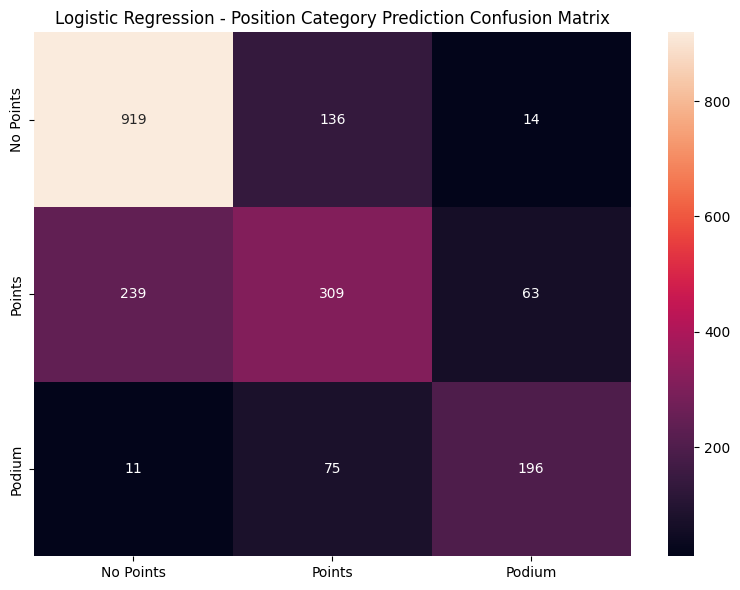

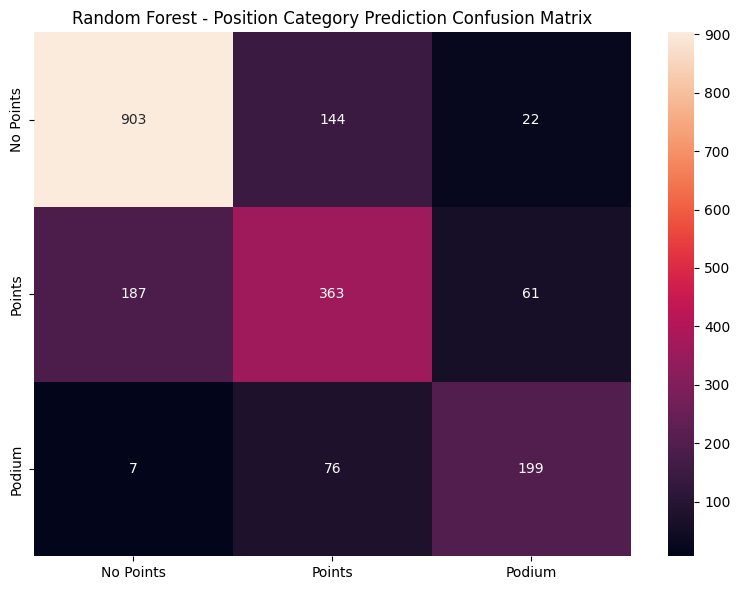

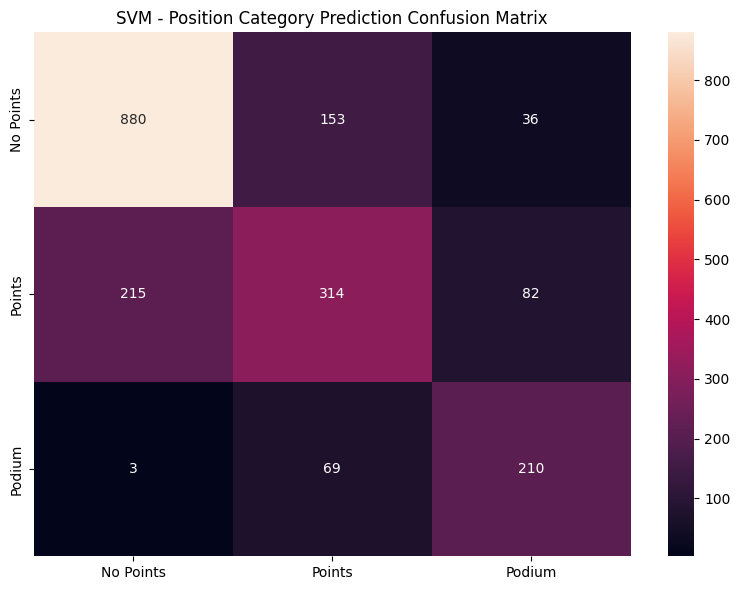

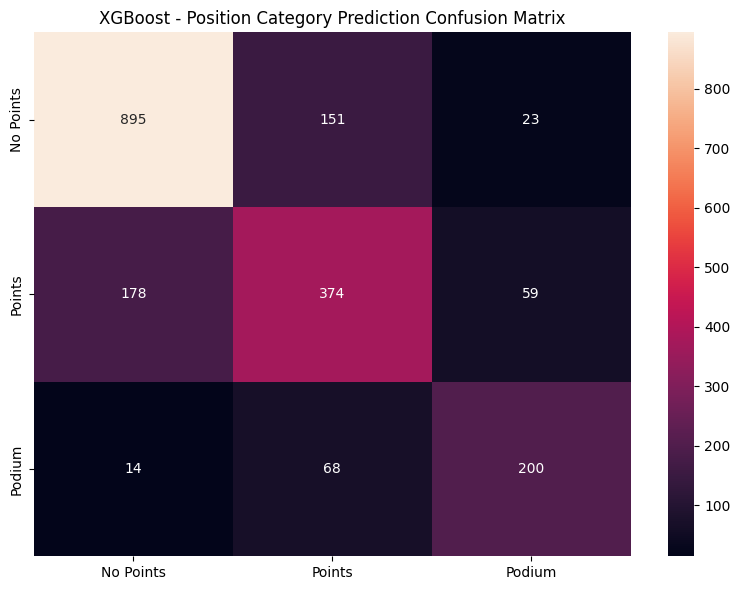

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

def create_position_categories(df):
    def categorize_position(position):
        if 1 <= position <= 3:
            return 2  # Podium
        elif 4 <= position <= 10:
            return 1  # Points
        else:
            return 0  # No Points
    
    df['position_category'] = df['position'].apply(categorize_position)
    return df

def prepare_multiclass_dataset(df):
    features = [
        'grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 
        'championship_position', 'circuitRef', 'round', 'number_wins', 
        'driver_country', 'constructor_name', 'country',
        'constructor_country', 'driver_name', 'year',
        'constructor_reliability', 'driver_reliability', 
        'driver_home_race', 'constructor_home_race', 'avg_performance_3'
    ]
    
    df = create_position_categories(df)
    X = df[features]
    y = df['position_category']
    
    return X, y

def create_preprocessor():
    numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year', 'avg_performance_3']
    numerical_features_unscaled = [
        'grid', 'total_points', 'championship_position', 'number_wins', 'driver_home_race', 'round',
        'constructor_home_race', 'constructor_reliability', 'driver_reliability'
    ]
    categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scaled', StandardScaler(), numerical_features_to_scale),
            ('num_unscaled', 'passthrough', numerical_features_unscaled),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])
    
    return preprocessor

def train_multiclass_models(X_train, y_train):
    preprocessor = create_preprocessor()
    
    models = {
        'Logistic Regression': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                multi_class='multinomial', 
                solver='lbfgs', 
                max_iter=1000
            ))
        ]),
        'Random Forest': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(
                n_estimators=100, 
                random_state=42
            ))
        ]),
        'SVM': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', SVC(
                probability=True, 
                random_state=42
            ))
        ]),
        'XGBoost': Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                use_label_encoder=False, 
                random_state=42
            ))
        ])
    }
    
    trained_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
    
    return trained_models

def evaluate_models(models, X_test, y_test, test_df):
    """
    Evaluate multiple models and generate comprehensive results
    
    Args:
        models (dict): Trained models
        X_test (pd.DataFrame): Test features
        y_test (pd.Series): Test target
        test_df (pd.DataFrame): Original test DataFrame
    
    Returns:
        dict: Evaluation results for each model
    """
    results = {}
    
    for name, model in models.items():
        # Predict
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        
        # Calculate race-wise accuracy
        race_ids = test_df['raceId']
        race_accuracy = calculate_race_position_accuracy(y_test, y_pred, race_ids)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Visualization
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', 
                    xticklabels=['No Points', 'Points', 'Podium'],
                    yticklabels=['No Points', 'Points', 'Podium'])
        plt.title(f'{name} - Position Category Prediction Confusion Matrix')
        plt.tight_layout()
        
        # Detailed metrics
        results[name] = {
            'race_accuracy': race_accuracy,
            'confusion_matrix': cm,
            'classification_report': classification_report(
                y_test, y_pred, 
                target_names=['No Points', 'Points', 'Podium']
            ),
            'accuracy_score': accuracy_score(y_test, y_pred),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
            'prediction_probabilities': y_pred_proba
        }
    
    return results

def calculate_race_position_accuracy(y_true, y_pred, race_ids):
    """
    Calculate race-wise accuracy for position predictions
    
    Args:
        y_true (array-like): True position categories
        y_pred (array-like): Predicted position categories
        race_ids (array-like): Unique race identifiers
    
    Returns:
        float: Average race-wise accuracy
    """
    results_df = pd.DataFrame({
        'race_id': race_ids,
        'true_category': y_true,
        'predicted_category': y_pred
    })
    
    race_accuracies = []
    
    for race_id in results_df['race_id'].unique():
        race_results = results_df[results_df['race_id'] == race_id]
        race_accuracy = (race_results['true_category'] == race_results['predicted_category']).mean()
        race_accuracies.append(race_accuracy)
    
    return np.mean(race_accuracies)

def main_multiclass_position_prediction_workflow(data):
    """
    Main workflow for F1 multiclass position prediction
    
    Args:
        data (pd.DataFrame): Input Formula 1 race data
    
    Returns:
        dict: Comprehensive model analysis results
    """
    # Preprocessing
    data = create_position_categories(data)
    
    # Prepare features and target
    X, y = prepare_multiclass_dataset(data)
    
    # Split the data (time series split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    
    # Train multiple models
    trained_models = train_multiclass_models(X_train, y_train)
    
    # Evaluate models
    evaluation_results = evaluate_models(
        trained_models, 
        X_test, 
        y_test, 
        data.loc[X_test.index]
    )
    
    return {
        'models': trained_models,
        'results': evaluation_results
    }


# Example usage (commented out for artifact):
# # Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')
data['date'] = pd.to_datetime(data['date'])
# 
# # Add custom features (assuming these functions exist)
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)
data = avg_performance_3(data)
# 
# Run the full workflow
results = main_multiclass_position_prediction_workflow(data)



In [91]:
# Race-wise accuracy for each model
for model_name, result in results['results'].items():
    print(f"{model_name} Race-wise Accuracy: {result['race_accuracy']:.4f}")

Logistic Regression Race-wise Accuracy: 0.7144
Random Forest Race-wise Accuracy: 0.7354
SVM Race-wise Accuracy: 0.6992
XGBoost Race-wise Accuracy: 0.7404


In [112]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Load the dataset
data = pd.read_csv('data/cleaned_data_EDA.csv')
data['date'] = pd.to_datetime(data['date'])

# Assuming you have a finishing position column named 'position'
# Create the three-class target
# 0 = podium (pos 1-3), 1 = points (pos 4-10), 2 = non-points (pos 11+)
data['finishing_group'] = data['position'].apply(lambda x: 0 if x <= 3 else (1 if x <= 10 else 2))

# Implement the new features (assuming these functions are defined)
data = calculate_constructor_reliability(data)
data = calculate_driver_reliability(data)
data = add_driver_home_race(data)
data = add_constructor_home_race(data)
data = avg_performance_3(data)

# Select features and target
features = [
    'grid', 'age_at_gp_in_days', 'q1_seconds', 'total_points', 'championship_position', 'circuitRef', 'round',
    'number_wins', 'driver_country', 'constructor_name', 'country','constructor_country', 'driver_name', 'year',
    # New features
    'constructor_reliability', 'driver_reliability', 'driver_home_race','constructor_home_race', 'avg_performance_3'
]

target = 'finishing_group'

# Subset the data
df = data[features + ['raceId', target]].copy()
df = df.dropna(subset=features + [target])

# Define categorical and numerical features
numerical_features_to_scale = ['age_at_gp_in_days', 'q1_seconds', 'year', 'avg_performance_3']
numerical_features_unscaled = [
    'grid', 'total_points', 'championship_position', 'number_wins',  'driver_home_race', 'round',
    'constructor_home_race', 'constructor_reliability', 'driver_reliability']
categorical_features = ['driver_country', 'constructor_name', 'country', 'constructor_country', 'driver_name', 'circuitRef']

# Split data into training and test sets based on year
train_df = df[df['year'] < 2020].reset_index(drop=True)
test_df = df[df['year'] >= 2020].reset_index(drop=True)

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

race_ids_test = test_df['raceId']
driver_names_test = test_df['driver_name']

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaled', StandardScaler(), numerical_features_to_scale),
        ('num_unscaled', 'passthrough', numerical_features_unscaled),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Function to calculate race-wise accuracy for multi-class
def calculate_race_wise_accuracy_multiclass(y_true, y_pred, race_ids):
    results_df = pd.DataFrame({
        'raceId': race_ids,
        'actual': y_true,
        'predicted': y_pred
    })

    unique_races = results_df['raceId'].unique()
    accuracies = []
    for race_id in unique_races:
        race_data = results_df[results_df['raceId'] == race_id]
        # Calculate the fraction of drivers for which the finishing group is predicted correctly
        race_acc = accuracy_score(race_data['actual'], race_data['predicted'])
        accuracies.append(race_acc)

    # Average race-wise accuracy
    return np.mean(accuracies) if len(accuracies) > 0 else 0

# Cross-validation function for multi-class race-wise accuracy
def cross_validate_race_wise_multiclass(model, X, y, df, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    race_wise_accuracies = []

    for train_index, val_index in tscv.split(X):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]
        df_val_fold = df.iloc[val_index].reset_index(drop=True)
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Fit the model
        pipeline.fit(X_train_fold, y_train_fold)
        
        # Predict on validation set
        y_pred_val = pipeline.predict(X_val_fold)
        
        # Calculate race-wise accuracy
        race_wise_acc = calculate_race_wise_accuracy_multiclass(
            y_true=y_val_fold.reset_index(drop=True),
            y_pred=y_pred_val,
            race_ids=df_val_fold['raceId']
        )
        race_wise_accuracies.append(race_wise_acc)

    return np.mean(race_wise_accuracies)

# Define the logistic regression model for multinomial classification
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

print("Processing Logistic Regression (Multi-class)...")
mean_race_wise_accuracy = cross_validate_race_wise_multiclass(model, X_train, y_train, train_df, n_splits=5)

# Fit on the entire training set
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])
pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_test = pipeline.predict(X_test)

# Calculate test race-wise accuracy
test_race_wise_accuracy = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test,
    race_ids=race_ids_test.reset_index(drop=True)
)

print("\nSummary of Results:")
print(f"Logistic Regression (Multi-class):")
print(f" - Mean Race-wise Accuracy on training data: {mean_race_wise_accuracy:.4f}")
print(f" - Race-wise Accuracy on test data: {test_race_wise_accuracy:.4f}")


Processing Logistic Regression (Multi-class)...

Summary of Results:
Logistic Regression (Multi-class):
 - Mean Race-wise Accuracy on training data: 0.7102
 - Race-wise Accuracy on test data: 0.7330


In [113]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model for multi-class classification
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

print("Processing Random Forest (Multi-class)...")
mean_race_wise_accuracy_rf = cross_validate_race_wise_multiclass(rf_model, X_train, y_train, train_df, n_splits=5)

# Fit the model on the entire training set
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_test_rf = rf_pipeline.predict(X_test)

# Calculate test race-wise accuracy
test_race_wise_accuracy_rf = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test_rf,
    race_ids=race_ids_test.reset_index(drop=True)
)

# Print summary of results
print("\nSummary of Results:")
print(f"Random Forest (Multi-class):")
print(f" - Mean Race-wise Accuracy on training data: {mean_race_wise_accuracy_rf:.4f}")
print(f" - Race-wise Accuracy on test data: {test_race_wise_accuracy_rf:.4f}")


Processing Random Forest (Multi-class)...

Summary of Results:
Random Forest (Multi-class):
 - Mean Race-wise Accuracy on training data: 0.7179
 - Race-wise Accuracy on test data: 0.7434


In [114]:
from sklearn.svm import SVC

# Define the SVM model for multi-class classification
svm_model = SVC(probability=True, class_weight='balanced', random_state=42, kernel='rbf')

print("Processing SVM (Multi-class)...")
mean_race_wise_accuracy_svm = cross_validate_race_wise_multiclass(svm_model, X_train, y_train, train_df, n_splits=5)

# Fit the model on the entire training set
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])
svm_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_test_svm = svm_pipeline.predict(X_test)

# Calculate test race-wise accuracy
test_race_wise_accuracy_svm = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test_svm,
    race_ids=race_ids_test.reset_index(drop=True)
)

# Print summary of results
print("\nSummary of Results:")
print(f"SVM (Multi-class):")
print(f" - Mean Race-wise Accuracy on training data: {mean_race_wise_accuracy_svm:.4f}")
print(f" - Race-wise Accuracy on test data: {test_race_wise_accuracy_svm:.4f}")


Processing SVM (Multi-class)...

Summary of Results:
SVM (Multi-class):
 - Mean Race-wise Accuracy on training data: 0.6539
 - Race-wise Accuracy on test data: 0.6812


In [115]:
from xgboost import XGBClassifier

# Define the XGBoost model for multi-class classification
xgb_model = XGBClassifier(
    objective='multi:softmax',  # Multi-class classification with class probabilities
    num_class=3,               # Three classes: podium, points, non-points
    use_label_encoder=False,   # Suppress label encoding warning
    eval_metric='mlogloss',    # Multi-class log loss
    random_state=42
)

print("Processing XGBoost (Multi-class)...")
mean_race_wise_accuracy_xgb = cross_validate_race_wise_multiclass(xgb_model, X_train, y_train, train_df, n_splits=5)

# Fit the model on the entire training set
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])
xgb_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_test_xgb = xgb_pipeline.predict(X_test)

# Calculate test race-wise accuracy
test_race_wise_accuracy_xgb = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test_xgb,
    race_ids=race_ids_test.reset_index(drop=True)
)

# Print summary of results
print("\nSummary of Results:")
print(f"XGBoost (Multi-class):")
print(f" - Mean Race-wise Accuracy on training data: {mean_race_wise_accuracy_xgb:.4f}")
print(f" - Race-wise Accuracy on test data: {test_race_wise_accuracy_xgb:.4f}")


Processing XGBoost (Multi-class)...

Summary of Results:
XGBoost (Multi-class):
 - Mean Race-wise Accuracy on training data: 0.7294
 - Race-wise Accuracy on test data: 0.7687


In [117]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

# Step 1: Recursive Feature Elimination (RFE) for Feature Selection
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
rfe = RFE(estimator=logistic_model, n_features_to_select=10, step=1)  # Adjust n_features_to_select as needed

# Fit RFE on the training data
X_train_processed = preprocessor.fit_transform(X_train)
rfe.fit(X_train_processed, y_train)

# Get the selected features
selected_features = rfe.get_support()
# Get the feature names after preprocessing
preprocessed_feature_names = (
    numerical_features_to_scale + 
    numerical_features_unscaled + 
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)
selected_feature_names = np.array(preprocessed_feature_names)[selected_features]
print("Selected Features:", selected_feature_names)

# Step 2: Hyperparameter Tuning with GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['lbfgs', 'saga'],  # Solvers for multinomial logistic regression
}
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000))
])

grid_search = GridSearchCV(
    logistic_pipeline, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Hyperparameters for Logistic Regression:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

# Step 3: Evaluate on Test Set
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
test_race_wise_accuracy = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test,
    race_ids=race_ids_test.reset_index(drop=True)
)

print("Test Race-wise Accuracy with Logistic Regression:", test_race_wise_accuracy)


Selected Features: ['avg_performance_3' 'constructor_name_Jaguar'
 'constructor_country_Malaysia' 'constructor_country_USA'
 'driver_name_Alexander Albon' 'driver_name_Carlos Sainz'
 'driver_name_Esteban Gutiérrez' 'driver_name_Mika Salo'
 'driver_name_Nico Hülkenberg' 'circuitRef_indianapolis']
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters for Logistic Regression: {'classifier__C': 10, 'classifier__solver': 'saga'}
Best CV Score: 0.7097610180743029
Test Race-wise Accuracy with Logistic Regression: 0.7373222530009232


In [119]:
# Feature Selection using Feature Importance
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_processed, y_train)

# Get feature importances
importances = rf_model.feature_importances_
important_indices = np.argsort(importances)[-10:]  # Select top 10 features
selected_feature_names_rf = np.array(features + ['year'])[important_indices]  # Ensure 'year' is included
print("Selected Features for Random Forest:", selected_feature_names_rf)

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [10, 20, None],     # Tree depth
    'classifier__min_samples_split': [2, 5, 10],  # Min samples to split
}
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

grid_search_rf = GridSearchCV(
    rf_pipeline, 
    param_grid_rf, 
    cv=5, 
    scoring='accuracy', 
    verbose=1
)
grid_search_rf.fit(X_train[selected_feature_names_rf], y_train)

# Evaluate Random Forest
print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)
y_pred_test_rf = grid_search_rf.best_estimator_.predict(X_test[selected_feature_names_rf])
test_race_wise_accuracy_rf = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test_rf,
    race_ids=race_ids_test.reset_index(drop=True)
)
print("Test Race-wise Accuracy with Random Forest:", test_race_wise_accuracy_rf)


Selected Features for Random Forest: ['driver_name' 'q1_seconds' 'constructor_name' 'number_wins'
 'age_at_gp_in_days' 'grid' 'circuitRef' 'championship_position' 'round'
 'total_points']
Fitting 5 folds for each of 27 candidates, totalling 135 fits


ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'year'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\__init__.py", line 448, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\base.py", line 3804, in get_loc
    raise KeyError(key) from err
KeyError: 'year'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 893, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\compose\_column_transformer.py", line 724, in fit_transform
    self._validate_column_callables(X)
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\compose\_column_transformer.py", line 426, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\joelc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\__init__.py", line 456, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe


In [120]:
# Use the selected features from RFE or another feature selection method

# Hyperparameter Tuning for SVM
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],   # Regularization strength
    'classifier__kernel': ['linear', 'rbf'],  # Kernel type
    'classifier__gamma': ['scale', 'auto'],   # Kernel coefficient
}
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, class_weight='balanced', random_state=42))
])

grid_search_svm = GridSearchCV(
    svm_pipeline, 
    param_grid_svm, 
    cv=5, 
    scoring='accuracy', 
    verbose=1
)
grid_search_svm.fit(X_train[selected_feature_names], y_train)

# Evaluate SVM
print("Best Hyperparameters for SVM:", grid_search_svm.best_params_)
y_pred_test_svm = grid_search_svm.best_estimator_.predict(X_test[selected_feature_names])
test_race_wise_accuracy_svm = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test_svm,
    race_ids=race_ids_test.reset_index(drop=True)
)
print("Test Race-wise Accuracy with SVM:", test_race_wise_accuracy_svm)


KeyError: "['constructor_name_Jaguar', 'constructor_country_Malaysia', 'constructor_country_USA', 'driver_name_Alexander Albon', 'driver_name_Carlos Sainz', 'driver_name_Esteban Gutiérrez', 'driver_name_Mika Salo', 'driver_name_Nico Hülkenberg', 'circuitRef_indianapolis'] not in index"

In [ ]:
# Use Feature Importance for Selection
xgb_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    eval_metric='mlogloss', 
    random_state=42
)
xgb_model.fit(X_train_processed, y_train)

importances_xgb = xgb_model.feature_importances_
important_indices_xgb = np.argsort(importances_xgb)[-10:]  # Select top 10 features
selected_feature_names_xgb = np.array(features)[important_indices_xgb]
print("Selected Features for XGBoost:", selected_feature_names_xgb)

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [50, 100, 200],      # Number of trees
    'classifier__max_depth': [3, 6, 10],            # Tree depth
    'classifier__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'classifier__subsample': [0.8, 1.0],            # Subsampling ratio
}
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        objective='multi:softmax', 
        num_class=3, 
        eval_metric='mlogloss', 
        random_state=42
    ))
])

grid_search_xgb = GridSearchCV(
    xgb_pipeline, 
    param_grid_xgb, 
    cv=5, 
    scoring='accuracy', 
    verbose=1
)
grid_search_xgb.fit(X_train[selected_feature_names_xgb], y_train)

# Evaluate XGBoost
print("Best Hyperparameters for XGBoost:", grid_search_xgb.best_params_)
y_pred_test_xgb = grid_search_xgb.best_estimator_.predict(X_test[selected_feature_names_xgb])
test_race_wise_accuracy_xgb = calculate_race_wise_accuracy_multiclass(
    y_true=y_test.reset_index(drop=True),
    y_pred=y_pred_test_xgb,
    race_ids=race_ids_test.reset_index(drop=True)
)
print("Test Race-wise Accuracy with XGBoost:", test_race_wise_accuracy_xgb)


train each model with only these features:

['avg_performance_3', 'grid', 'total_points', 'championship_position', 'number_wins', 'constructor_reliability', 'driver_reliability']